# Generate MNIST digits using GAN

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import keras
from keras import layers as L
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Some constants
img_height = 64
img_width = 64
img_channels = 3
img_shape = (img_height, img_width, img_channels)
latent_dim = 100
batch_size = 64
n_epochs = 50000
img_path = r"C:\__MyComputer\OneDrive - Teradata\Drive_SM\Course\analyticsvidhya\facecounting\image_data"
img_path = r"/home/dell/sm186047/gan/simpsons_faces_cropped/"

In [3]:
# save the generated images
def sample_images(generator, epoch):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images
    gen_imgs = ((gen_imgs+1)*127.5).astype(np.float)
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("gen_images/%d.png" % epoch)
    # plt.show()
    # plt.close()

In [4]:
# Loss functions
from keras.applications.vgg16 import VGG16


def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))


def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [5]:
# define the generator
def build_generator():

    model = Sequential()

    model.add(L.Dense(256*8*8, input_dim=latent_dim))
    model.add(L.Reshape((8, 8, 256)))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.Conv2DTranspose(filters = 256,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Activation("relu"))
    model.add(L.Conv2DTranspose(filters = 128,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Conv2DTranspose(filters = 3,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(L.Activation("tanh"))
    model.name = 'G'
    model.summary()

    noise = L.Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [6]:
# define the discriminator
def build_discriminator():

    model = Sequential()
    
    model.add(L.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', input_shape=img_shape))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Conv2D(filters=512, kernel_size=(3, 3), strides=2, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Flatten())
    model.add(L.Dense(512))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.Dense(256))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.Dense(1, activation='sigmoid'))
    model.name = 'D'
    model.summary()

    img = L.Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [7]:
def generator_containing_discriminator(generator, discriminator):
    # Set discriminator weights to non-trainable
    # (will only apply to the `gan` model)
    discriminator.trainable = False

    inputs = L.Input(shape=(latent_dim,))
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    gan = Model(inputs=inputs, outputs=outputs, name='gan')
    gan.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = 5E-4,
            beta_1=0.5, beta_2=0.999, epsilon=1e-08
        ),
        metrics = ['acc']
    )
    gan.summary()
    return gan


def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = L.Input(shape=(latent_dim,))
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs], name='DonGM')
    model.summary()
    return model

In [8]:
def train_multiple_outputs(log_dir=r'log', epoch_num=n_epochs, critic_updates=2):
    print("Image path", img_path)
    datagen = ImageDataGenerator( 
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False,
        shear_range=0.1
        ).flow_from_directory(
                img_path,
                # '../input/all-dogs/',
                target_size=(img_height, img_width),
                batch_size=64)
    imgs, _ = next(datagen)
    print(imgs.shape)
    from keras.preprocessing import image
    plt.imshow(image.array_to_img(imgs[3]))

    plt.show()

    g = build_generator()
    g.compile(loss = 'binary_crossentropy',
              optimizer = Adam(
              lr = 1E-4,
              beta_1=0.5, beta_2=0.999, epsilon=1e-08
            ),
            metrics = None)
    
    d = build_discriminator()
    d.compile(loss = 'binary_crossentropy',
              optimizer = Adam(
              lr = 1E-4,
              beta_1=0.5, beta_2=0.999, epsilon=1e-08
            ),
            metrics = None)
    
    gan = generator_containing_discriminator(g, d)

    for epoch in tqdm_notebook(range(epoch_num)):
        d_losses = []
        gan_losses = []
        for idx in tqdm_notebook(range(len(datagen)), total=len(datagen)):
            
            batch_size = len(datagen[idx][0])
            
            # Adversarial ground truths
            output_true_batch = np.ones((batch_size, 1))
            output_false_batch = np.zeros((batch_size, 1))
            
            # Select a batch of images
            imgs = datagen[idx][0]
            real_imgs = (imgs - 127.5) / 127.5

            d_loss = 0.0
            for i in range(2):
                # noise vector for generator
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                # generated images
                generated_images = g.predict(x=noise, batch_size=batch_size)

                # combined dataset for discriminator
                combined_imgs = np.concatenate([generated_images, real_imgs])
                combined_target = np.concatenate([output_false_batch, output_true_batch])
                # Add random noise to the labels
                combined_target += 0.05 * np.random.random(combined_target.shape)

                # train discriminator
                d_loss += d.train_on_batch(combined_imgs, combined_target)
                
            d_losses.append(d_loss/2.0)

            # d.trainable = False
            
            # We try to mislead the discriminator by giving the opposite labels
            fake_y = (np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2)
            gan_loss = gan.train_on_batch(noise, fake_y)
            gan_losses.append(gan_loss)

            # d.trainable = True

        print(epoch, np.mean(d_losses), np.mean(gan_losses))
        # If at save interval => save generated image samples
        if epoch % 1 == 0:
            # Save model weights
            gan.save_weights('gan.h5')
            sample_images(g, epoch)
            # save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))


Image path /home/dell/sm186047/gan/simpsons_faces_cropped/
Found 9877 images belonging to 1 classes.
(64, 64, 64, 3)


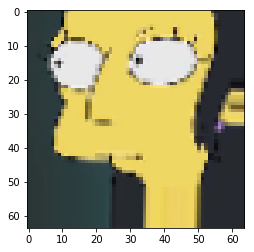

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0         
__________

/home/dell/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 -0.1282121316199341 0.17902246


1 -0.14229920266136045 0.16447805


2 -0.13992287189729752 0.1637154


3 -0.14056386721711006 0.16242674


4 -0.1393302774958072 0.1635125


5 -0.13941298932317764 0.16350068


6 -0.14022774619440878 0.16215825


7 -0.14266353304828366 0.1637988


8 -0.1406405887296123 0.16365476


9 -0.14230638156014105 0.16118951


10 -0.14084857437879808 0.16329198


11 -0.14054634239404432 0.162964


12 -0.14218996402717407 0.16225974


13 -0.1408422316995359 0.16228531


14 -0.13866913239321402 0.1637508


15 -0.14062012078300598 0.16241828


16 -0.1393712658555277 0.16252515


17 -0.14035370926703175 0.16316305


18 -0.14042847077212026 0.16254613


19 -0.14053849034732388 0.16181123


20 -0.14050808113909538 0.1621217


/home/dell/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 -0.13982327782338666 0.16276623


22 -0.14174043959186924 0.16185777


23 -0.14111502254682204 0.16229792


24 -0.14152624938757188 0.16378807


25 -0.0016915717252319858 0.6886604


26 0.004028190136136067 0.49254563


27 0.0012240333212239127 0.44844124


28 0.003486445209672374 0.40866902


29 0.0032262847338232303 0.39156887


30 0.0007985796088412885 0.38353837


31 0.0026069468007453027 0.3899303


32 0.002599236843807082 0.36391556


33 0.003727064625690541 0.3654257


34 0.0012199179900269355 0.34292915


35 0.002576435529326479 0.3379144


36 0.004030589122445353 0.3336668


37 0.0017698412055089589 0.3256197


38 0.001308276528312314 0.31023088


39 -0.00046799535893144145 0.31235167


40 0.0023179408989005513 0.3099924


41 0.0016880247050956373 0.30558097


42 0.004431134504416297 0.30230933


43 0.0010977079430895466 0.29411423


44 0.0019818812180610913 0.29713866


45 0.0014620352776781205 0.29285538


46 0.0023842607354444844 0.29123145


47 0.0009716348591140441 0.29201728


48 0.0023658154044120063 0.2953185


49 0.002013981240170617 0.2861778


50 3.1935796141624453e-05 0.28210804


51 0.003636702174140561 0.2835528


52 0.0034783718897210014 0.28125829


53 0.004068933823896993 0.28980294


54 0.0011805571856037262 0.27357668


55 0.0010392645434025795 0.27941555


56 0.002802787396696306 0.26775116


57 0.001960816773616018 0.2740331


58 0.0014331828051757428 0.27284363


59 0.0025291894292158467 0.2674409


60 0.002427198713825595 0.26872754


61 0.002141886360702976 0.25959742


62 0.003554879738799026 0.26280788


63 0.003181872757211808 0.26889163


64 0.003919343112577354 0.26640463


65 0.0018710112018931297 0.26271918


66 0.0030557460301826075 0.2618833


67 0.00485146084590064 0.26490563


68 0.002784837522513924 0.40437925


69 0.0022049206098721874 0.28651005


70 0.002854878040811708 0.2749167


71 0.0028658802591023905 0.2695156


72 0.0037196694272420097 0.26854587


73 0.0037736357820610847 0.2631168


74 0.005768673698748312 0.26159


75 0.0012923532916653542 0.26339155


76 0.0015727154662712446 0.25985786


77 0.0011594709189188097 0.25361308


78 0.0015813904566570156 0.25363886


79 0.0018649782459702223 0.25266823


80 0.0017888928493184429 0.26140377


81 0.0021173084518992373 0.25156537


82 0.0038286008992262427 0.25704327


83 0.0011154908326364333 0.2509844


84 0.002502512448136845 0.25422502


85 0.0014322022667094584 0.25112548


86 0.004240393975088673 0.25006872


87 0.002986832717320912 0.25112104


88 0.0027510496757684215 0.2455714


89 0.0031122624814029663 0.24750564


90 0.0025404795343356747 0.24380614


91 0.003932936698566341 0.24973936


92 0.003152378668798314 0.25911823


93 0.0014540785923600197 0.25096363


94 0.0023644664354862707 0.24871607


95 0.0008911670275753544 0.2462992


96 0.0033362252697829277 0.24595517


97 0.0036479013821771066 0.24577917


98 0.0024156323844386684 0.24747632


99 0.0036624691899745693 0.2423462


100 0.0022276903803069743 0.25482085


101 0.0020619978437260273 0.24944252


102 0.0031171807839024453 0.24373184


103 0.0016634873595208891 0.2471394


104 0.0021875128579971893 0.24568434


105 0.002846888056205165 0.2464004


106 0.002125670598639596 0.24945639


107 0.004030370084388602 0.23874925


108 0.00443159082994586 0.2455972


109 0.0019672056014138845 0.24183448


110 0.0023987725377082824 0.24196108


111 0.002810593646380209 0.24640316


112 0.0007918754051769933 0.23548779


113 0.0019248655189820114 0.24421537


114 0.00140933450611849 0.24278171


115 0.0025191910024131496 0.24394086


116 0.001727346333885385 0.23745127


117 0.00247005668859328 0.23508158


118 -0.0006903953730098663 0.23858687


119 0.001991730980995682 0.23609294


120 0.0017215739094441937 0.24345477


121 0.0019964909436361446 0.23285769


122 0.0030542364494214134 0.23329364


123 0.0011902008596206865 0.22491466


124 0.004210016564015419 0.24075578


125 0.00225137930603758 0.23308375


126 0.0008254114177919203 0.23897927


127 0.002877290054194389 0.23599896


128 0.0015854668112531786 0.22377865


129 0.002372132878630392 0.23409724


130 0.0003570210999779163 0.23290117


131 0.0034123737274879408 0.22402754


132 0.0016005073313511188 0.23009363


133 0.0005821528934663342 0.22700474


134 0.0018307699221036128 0.23888727


135 0.0015703755220578563 0.23279719


136 0.0026015355462028133 0.23192763


137 0.002633771584219029 0.22211419


138 0.0015845721061792104 0.23075935


139 0.001683616112436979 0.23277467


140 0.001857937722196502 0.22368199


141 -0.000336906673657077 0.23093161


142 0.0027637413026945245 0.22494207


143 0.0017938303843801542 0.23099458


144 0.0014958743276374956 0.21992636


145 0.003925860438856387 0.21759215


146 0.00114008792105221 0.22148438


147 0.001931176749208281 0.21467409


148 0.003061429645505644 0.21926309


149 0.004749228661098788 0.22332133


150 0.02869046395494332 0.5136047


151 0.0015657779069677476 0.7926089


152 0.001150979106164267 0.797065


153 -0.0004781820210477998 0.803101


154 0.0050374519800947554 0.7914587


155 0.0031047962846294528 0.79918116


156 0.001675366472092367 0.80652523


157 0.0034211205799252755 0.7957759


158 0.002674748848432735 0.8039394


159 0.0017922978044577664 0.8016045


160 0.002394261673813866 0.79871315


161 0.0019202053546905518 0.79615796


162 0.0010422747401941208 0.78893083


163 0.0026162571078466794 0.78996545


164 0.0008350281765864741 0.79278183


165 0.0028366864989361456 0.8010271


166 0.002657009342745427 0.798033


167 0.0007080841272498571 0.7908077


168 0.001867402020481325 0.7934365


169 0.002076434464223923 0.7993129


170 0.0019097145091021253 0.7985205


171 0.0026355970350484693 0.7993345


172 0.0026158574762971953 0.79404795


173 0.00034772127776617004 0.79941463


174 0.0021087577130885853 0.79317683


175 2.954811188242128e-05 0.80463266


176 -3.1159938343109625e-05 0.79157007


177 0.0014043996711411784 0.7914648


178 0.003334804729092866 0.79291356


179 0.003521314792094692 0.80041903


180 0.0024058982880125123 0.78630054


181 0.0031676358280463084 0.79931474


182 0.0036111573132896614 0.80368525


183 0.003682097335976939 0.7971693


184 0.0013544946067756223 0.7920114


185 0.004502659725145467 0.79473716


186 0.0019692635223750145 0.7973538


187 0.0017195953416728204 0.80086786


188 0.0017384031291810735 0.7935303


189 0.004384810110974697 0.79402435


190 0.0006037709062858936 0.79596615


191 0.0018162851251902119 0.7986204


192 0.0032783717247507264 0.8010092


193 0.0031674021712294028 0.80244976


194 0.00201232502492325 0.801056


195 0.0019641872795839463 0.7908461


196 0.0028174166237154314 0.7965271


197 0.0033609137599987368 0.79245645


198 0.002144134405159181 0.7965855


199 0.0019148398945558697 0.79949784


200 0.002381397351141899 0.7938853


201 0.000808514816866767 0.79554665


202 0.002761808966076182 0.8074717


203 0.003451842714040991 0.7969241


204 0.0016828586392465138 0.7968591


205 0.001631108857691288 0.7985511


206 0.004514907964415127 0.79503393


207 0.003096471534621331 0.79708743


208 0.0025721173973814134 0.8024239


209 0.0026246277194830678 0.80290645


210 0.0034592100449146765 0.80228066


211 0.002315611524447318 0.7981729


212 0.0021250500974635926 0.80102855


213 0.0034262742921372033 0.79568344


214 0.00210421928655236 0.80335


215 0.0018600389481552185 0.79992664


216 0.002101432748379246 0.8025627


217 0.0023086383428064083 0.79334825


218 0.0032318582818392783 0.8019193


219 0.0036925845711882556 0.7958107


220 0.002395186915753349 0.79200953


221 0.0017408949540807836 0.7973172


222 0.00420528489255136 0.79503876


223 0.0012792399243241356 0.7865665


224 0.003928344800407367 0.79826176


225 0.0027769843536999917 0.79793036


226 0.0029245744188947063 0.7986231


227 0.0033972545647092405 0.7950568


228 0.0018253836480359878 0.79006004


229 0.002448163608900241 0.7940448


230 0.003460115035094561 0.79785204


231 0.0026660390468614716 0.8020532


232 0.001997406876856281 0.80085284


233 0.003265813858278336 0.79751784


234 0.004167128771904015 0.7928742


235 0.0006555894810345866 0.79589874


236 0.0006579695733249068 0.79754174


237 0.003851152172372226 0.7917618


238 0.002177141388998397 0.8010688


239 0.0029019583583689266 0.78991044


240 0.0031715647587853093 0.78965676


241 0.002616597796159406 0.7955197


242 0.00287864834310547 0.7959572


243 0.0005989842717686007 0.79458606


244 0.004412653273151767 0.7915244


245 -0.0005151247004828145 0.7902062


246 0.00179509942329699 0.8006028


247 0.004992882168341067 0.7971176


248 0.002883914383428712 0.7966037


249 0.0027534727608003926 0.7939819


250 0.0022685321183094093 0.8014933


251 0.002000754987520556 0.8015931


252 0.002351599288803916 0.7880373


253 0.0007900966451533379 0.7956485


254 0.0022280129814340223 0.7932031


255 0.0009111662815895773 0.7954633


256 0.0015159693681785177 0.8012836


257 0.004827633198170412 0.8115894


258 0.0009187556202373197 0.79757714


259 0.0008763880739288946 0.7905535


260 0.0027471557030484322 0.80633


261 0.0008518469069273241 0.8020538


262 0.0016545191978014284 0.79607004


263 0.003136970977028531 0.79870987


264 0.0017937322958342492 0.7975011


265 0.0027310295541199945 0.79297817


266 0.003096821796028845 0.7957358


267 0.0012261403003527272 0.7907497


268 0.00255534065560618 0.8013264


269 0.00401276521564972 0.7959764


270 0.001969398143551042 0.79715466


271 0.0014024672579140433 0.8060064


272 0.00294604173771316 0.79906124


273 0.0025436713840932615 0.79877096


274 0.004033539483263608 0.797783


275 0.004005560175245327 0.7937448


276 0.005038824665450281 0.8000026


277 0.0011074190681439734 0.79763675


278 0.0038913289145115883 0.7905784


279 0.0037670244252489458 0.7896384


280 0.0012414042447363176 0.79870886


281 0.002906090177355274 0.80035466


282 0.001829831999155783 0.8027112


283 0.0024640048223157083 0.80166197


284 0.0022591104370451743 0.7944707


285 0.0023320655484924155 0.7977898


286 0.0024637648415180946 0.79411644


287 0.0025607012152191132 0.7988482


288 0.0017291243398381818 0.79611516


289 0.0025987944776012053 0.79363877


290 0.0013968585629857355 0.7923383


291 0.001885201993788923 0.8055294


292 0.0020328386206059684 0.7941359


293 0.0012891265773965466 0.7964503


294 0.0022445207221373437 0.79569256


295 0.001687003831349073 0.8008469


296 0.0020810432491763947 0.79694986


297 0.0006898989240008015 0.79465556


298 0.0007171778669280391 0.78476995


299 0.004575183559509535 0.8086815


300 0.0025618193550936636 0.79107857


301 0.0028186549702959676 0.8001534


302 0.0021498224788135097 0.79880226


303 0.0022208531297022295 0.7985366


304 0.00010631615896859476 0.79564166


305 0.0012388645821521359 0.79634696


306 0.0018509726550790572 0.8015847


307 0.004662747837362751 0.7974559


308 0.00029027335225574434 0.7988476


309 0.001962728864483295 0.7967575


310 0.003333346629815717 0.8000638


311 0.0006539708311339059 0.79280937


312 0.0033170629833494465 0.8024237


313 0.0025681950933029575 0.80021995


314 0.0035473293955287626 0.80495256


315 0.001377836029015241 0.7940246


316 0.0011089218239630422 0.79943174


317 0.003748796687972161 0.79773164


318 0.0019137057340553691 0.7931592


319 0.0003220340056765464 0.7965148


320 0.003329831313702368 0.79770505


321 0.0008272411421902719 0.8006976


322 0.001595355129440225 0.80827117


323 0.0016140211388588914 0.7972478


324 0.0008727523588365124 0.7933323


325 0.0010005889039847158 0.795198


326 0.001969467944675876 0.7941114


327 0.001236020402622319 0.79392266


328 0.002452214316074406 0.79162025


329 0.004015683400775156 0.7950347


330 0.00047955342057731844 0.8035821


331 0.001959143149396104 0.7955979


332 0.0021877303298923276 0.80270666


333 0.0029784844046638857 0.7963538


334 0.00017334531294181942 0.8018235


335 0.0037512379127644722 0.79834783


336 0.0029035944251283525 0.80391985


337 0.001902849674825707 0.79924977


338 -0.00026640171155093177 0.793779


339 0.0003712458325730216 0.79485214


340 0.002599246421408269 0.7948237


341 0.0013033312985733633 0.79287314


342 0.0019418755966809488 0.7913771


343 0.0020725175017310728 0.7955756


344 0.0013022007841256356 0.79445416


345 0.004039123990843373 0.80379826


346 0.00040255488655079275 0.79288036


347 0.0022961860702883814 0.80395555


348 0.0008152221750107504 0.79142046


349 0.0024591605389310467 0.7963631


350 0.002051535981797403 0.7937083


351 0.0018011428355689972 0.79165


352 0.0026339433486423183 0.7921315


353 0.0015123936497876721 0.795225


354 0.0017699846614813131 0.7975581


355 0.002154309371666562 0.787674


356 0.0016850397771885318 0.7960212


357 0.0021642404338044507 0.8042624


358 0.002270779662555264 0.7951219


359 0.0006691198856119187 0.79659694


360 0.0017188394198104017 0.7880752


361 0.000862366106781748 0.7984828


362 -0.001095793774772075 0.79695016


363 0.003410926389117395 0.7998483


364 0.0027114147140133767 0.78941137


365 0.0017977718023523207 0.7977635


366 0.003684459575602124 0.79367816


367 0.004004998946742665 0.79519457


368 0.00393803822958181 0.7907669


369 0.001342458845747094 0.7916436


370 0.003434617216548612 0.7958943


371 0.0021782622101806826 0.80145097


372 0.0006393918354484823 0.7979604


373 0.0017082782041641974 0.7970339


374 0.0017636084147999364 0.80721986


375 0.0038756216245312844 0.79196507


376 0.0029270194102859787 0.7957551


377 0.0006620349137172584 0.7968998


378 0.0006285012519407657 0.80180234


379 -0.001220573659145063 0.80237764


380 0.0009234031422003623 0.80430675


381 0.002174358370323335 0.7819212


382 0.0032659949494465703 0.80386275


383 0.0034454846289008858 0.8025049


384 0.003527560703186018 0.7991148


385 0.0016348798428812334 0.80369544


386 0.004742508367851241 0.79585487


387 0.0018163341908685622 0.7989636


388 0.000854271145597581 0.7963837


389 0.0016745032156787573 0.7928187


390 0.00015449265558873453 0.8017079


391 0.003650756907318869 0.7932707


392 0.003324074706723613 0.8071617


393 0.00228912539239372 0.7859808


394 0.004726843752207294 0.7914379


395 0.001998412194511583 0.7948425


396 0.003228644666171843 0.78752834


397 0.0004578804319363929 0.8015706


398 0.0019851029279731934 0.78986907


399 0.002580833365960467 0.7901166


400 0.0027373017217483253 0.7951029


401 0.0008953192661846838 0.79953754


402 0.003565254400769669 0.79539126


403 0.003212858628361456 0.79317033


404 0.0030888464241739244 0.7964305


405 0.002165059393812572 0.7978439


406 0.004363907173073159 0.803565


407 0.0001730995162600471 0.7968336


408 0.0016295960127946831 0.7971128


409 0.00262071778096499 0.79648525


410 0.0038031575540381094 0.7970314


411 0.002946140058338642 0.79244584


412 0.0019582854103176823 0.79460645


413 0.005078644527783317 0.7945718


414 0.001499493071629155 0.8004496


415 0.00027045782264922895 0.7891634


416 0.00011306430303281354 0.7972114


417 0.0028549954595585023 0.79876167


418 0.0017772109679607374 0.79867125


419 0.0020217729792479547 0.80521494


420 0.001241920672116741 0.80129194


421 0.0033146193070757776 0.7989927


422 0.0012672114606586194 0.8024676


423 0.0013585598358223515 0.79601836


424 0.0024846025832718417 0.8005617


425 0.0018626262313656268 0.7983861


426 0.0009562360843823802 0.8021567


427 0.0008828719356848348 0.8015297


428 0.0013861211407328806 0.7930979


429 0.0028236618445765587 0.80091757


430 0.0017375509464933026 0.79199404


431 0.0023627213292544886 0.8029424


432 0.0008684442648964544 0.79364187


433 0.0019737964195589864 0.7972741


434 -0.0007603252381687203 0.8052364


435 0.00019334483771554886 0.7887549


436 0.0015929023825353192 0.7982309


437 0.0024436427039965505 0.8023863


438 0.0020006444785864125 0.80333525


439 0.002708971211987157 0.7945538


440 0.0027133764518845467 0.8064366


441 0.0019917784078467278 0.80026203


442 0.0017610732420918441 0.8037724


443 0.002251447480352175 0.7983692


444 0.0013365281069831502 0.79133457


445 0.003992672757275643 0.7937027


446 0.0017454914808753999 0.7986716


447 0.002268354510588031 0.79444975


448 0.0032589087683346962 0.79539984


449 0.0023761790546198043 0.7914322


450 0.0043581681115733035 0.80188453


451 0.0024845798150636257 0.7885339


452 0.00399390310049057 0.7916852


453 0.003978145993765323 0.80024654


454 0.004334939998244086 0.7998614


455 0.0013308363275662545 0.79716384


456 -0.001134034234189218 0.7977724


457 0.0035068154935875245 0.79353213


458 0.003310049328232004 0.80179894


459 0.0030638521627312705 0.7935894


460 0.0009173337850839861 0.7876718


461 0.0006397542273325305 0.79349446


462 0.0028733180655587105 0.79244924


463 0.001142471079384127 0.79752475


464 0.0013657057477581885 0.7971293


465 0.0025697179739513705 0.8010645


466 0.0042468730240098895 0.798312


467 0.004290425582157989 0.79231673


468 0.0025184781320633427 0.79448


469 0.0014589917725853381 0.7920638


470 0.001776201614449101 0.7922708


471 0.0023393093217765133 0.8015247


472 0.0012714637623679253 0.79900545


473 0.0023154281440281098 0.8000219


474 0.0032373760436331073 0.7968987


475 0.001919151259766471 0.7986881


476 0.0016010691592049215 0.79772264


477 0.0029864840096824113 0.7942035


478 0.001390633500751949 0.79449993


479 0.0024281760437353966 0.7892669


480 0.0025995736881609887 0.8062088


481 -0.0005439728438373535 0.803966


482 0.0029359841186012473 0.79805964


483 0.00027963930680867166 0.8025989


484 0.002189875150760335 0.8016072


485 0.0018603284332540727 0.7924483


486 0.0018899063369439495 0.79524446


487 0.0027224604040384293 0.8048587


488 0.00251715024482579 0.80123687


489 0.002434801778966381 0.7986911


490 0.0016003591999892266 0.79374385


491 0.002622434523917975 0.7990772


492 0.0031491425399097703 0.804244


493 0.0025195971762220705 0.7940839


494 0.0034453416348344855 0.7950684


495 0.0010004193522036076 0.7976064


496 0.00254739107894561 0.79434615


497 0.0030931124043080114 0.7935949


498 0.00046254073780390526 0.80315965


499 0.003398951876067346 0.7999003


500 0.002530085616895268 0.79422736


501 0.0037869546983030533 0.7996121


502 0.002265462081038183 0.79414606


503 0.002815309653599416 0.79784936


504 0.0026932949320443217 0.8010854


505 7.58788338111293e-05 0.79498136


506 0.0009768839685186262 0.7915245


507 -0.00019162331797903585 0.7955339


508 0.004182208689951127 0.7992038


509 0.0018522756114121405 0.79794747


510 0.004239648066821598 0.79897875


511 0.0013644779912166058 0.7915328


512 0.000644010613341966 0.7901019


513 0.0029151235399166903 0.79014945


514 -6.661554948697167e-05 0.798414


515 0.0014210517247838358 0.80049145


516 0.003333047404885292 0.7953631


517 0.002856112511888627 0.7919576


518 0.001551325126521049 0.79876935


519 0.0017919740143923029 0.7961847


520 0.001272904530407921 0.8030557


521 0.00217136419716201 0.7969415


522 0.00023078199836515612 0.7961415


523 6.650977077022675e-06 0.7932112


524 0.0032095707592464263 0.7972941


525 0.0022068831949464737 0.7969303


526 0.004200816827435647 0.79612154


527 0.00340575827586074 0.8025448


528 0.0013492819387465715 0.8007213


529 0.004658506420110503 0.7911672


530 0.0021605447114955993 0.7981512


531 0.003176523168240824 0.8000911


532 0.0027878118558756766 0.80065095


533 0.0033048721210610483 0.7983501


534 0.00259704033303405 0.7987157


535 0.001328456116419646 0.7982735


536 0.0017186389229590854 0.78783816


537 0.0019639007476789337 0.79620826


538 0.004410072618855104 0.80119026


539 0.0008767597978153537 0.7903923


540 0.004401941034912823 0.7931407


541 0.0031689992805402126 0.79290885


542 0.0005531543925885231 0.79964507


543 0.0028197188696433458 0.8061785


544 0.00253022191445193 0.79382515


545 0.0033242034466726884 0.80458766


546 0.0014980894708705526 0.79712766


547 0.002089710825032765 0.7885314


548 0.002087431629338572 0.79468024


549 0.0023639551844568023 0.7949534


550 0.002492133488938693 0.805188


551 0.0024967531538418225 0.80329174


552 0.0028032217294939104 0.79643404


553 0.0034984983203391875 0.79937184


554 0.0026863742980264846 0.79467595


555 -0.0008058490291718513 0.79519755


556 0.00372013027869886 0.78949887


557 0.0009016928383179249 0.79991573


558 0.0002668131428259996 0.8005552


559 0.0023869279291360607 0.80003345


560 0.0027410771836706947 0.8026648


561 0.002146940257760786 0.7987536


562 0.001641634647403994 0.79294246


563 0.0017448122222577373 0.79687107


564 0.003576812941220499 0.80306345


565 0.0017030918309765477 0.80641496


566 0.00223206719684024 0.80122906


567 0.0014883688620982631 0.7987433


568 0.002763423059255846 0.7915567


569 0.0013647685848897503 0.79796606


570 0.0035161505843843183 0.8061081


571 0.0014899859325058998 0.79678655


572 0.002379852605442847 0.79815686


573 0.0017730975193121742 0.7957235


574 0.003915088131062446 0.79674375


575 0.0029911387591592727 0.7960761


576 0.0009773891178830978 0.7972855


577 0.0034616353260653633 0.7939975


578 0.004099994444198185 0.79492456


579 0.0012409660991022154 0.8004291


580 0.0019173865567051595 0.78527135


581 0.0018364432958825941 0.7891747


582 0.0018484044805048936 0.7874821


583 0.0018727558139230937 0.78844595


584 0.003204851692181922 0.79729277


585 0.002357475411507391 0.8053127


586 0.002351408824324608 0.80278605


587 0.0008746405522669516 0.78991


588 0.002134410856712249 0.7997283


589 0.0035813732493308282 0.78856874


590 0.003245506660952683 0.79612434


591 0.002691064360401323 0.79479456


592 0.004458199020835661 0.79127264


593 0.0028137795747287813 0.80721456


594 0.0029087338613950826 0.8042737


595 0.003621380728098654 0.7953708


596 0.002795793010943359 0.7999855


597 0.0016981931944047251 0.79938096


598 0.0006537467241287231 0.7965005


599 0.003056350293298883 0.7876306


600 0.0026278914222794196 0.79336566


601 0.004884948644546732 0.8021992


602 0.0024126563491600173 0.78757066


603 0.0032991784714883374 0.7934238


604 0.003725079398962759 0.7914933


605 0.0013818772419566109 0.80095947


606 0.004673842552884091 0.79502356


607 0.001210720777030914 0.7978928


608 0.0011141033152178412 0.7972226


609 0.004454693937253567 0.8004696


610 0.004455585194931876 0.79897046


611 0.0029317244526840024 0.80097556


612 0.0005119932875517876 0.80018824


613 0.0011850569292061752 0.8016859


614 0.0018001619486078138 0.7984069


615 0.00254236823774033 0.7948061


616 0.004603418963210237 0.8033175


617 0.0014982926689328685 0.797429


618 0.003435102916292606 0.8037295


619 0.001454404212774769 0.79743505


620 -0.0002509097538648113 0.801185


621 0.0021027758477195615 0.79877394


622 0.0029843587127904737 0.80171305


623 0.0018999265120064298 0.8022776


624 0.00371771133054168 0.7975078


625 0.002793842049375657 0.79854697


626 0.001725030432064687 0.79774374


627 0.0017263633559548087 0.7916413


628 0.0032636212245110542 0.7982293


629 0.0013266855790730445 0.8011327


630 0.001442715102025578 0.7931677


631 0.002710728800945705 0.7944912


632 0.002674299096989055 0.7911637


633 0.002588579082681287 0.7989321


634 0.004694085790505332 0.7974671


635 0.0033556863305068785 0.7918041


636 0.0031094085785650437 0.80101687


637 -0.000130390279716061 0.7996268


638 0.000504347994442909 0.805931


639 0.0030791486523324444 0.78903276


640 0.0015213358762505983 0.801215


641 0.002177089250706617 0.80030805


642 0.0021014901959607677 0.790766


643 0.0018431400669918906 0.7955143


644 0.0034914741352681192 0.79762906


645 0.0001372034150746561 0.7958936


646 0.0011472103321143697 0.7917923


647 0.0012597898562108317 0.79334605


648 0.0022321436328873517 0.8038968


649 0.0020653883935958747 0.8040744


650 0.003973179719140452 0.8002552


651 0.0024639158299373043 0.79075646


652 0.00189908075957529 0.79341274


653 0.0026834805586164997 0.80150765


654 0.001531781718855904 0.79921454


655 0.0024466209353939177 0.79259413


656 0.0022950780307573657 0.7995182


657 0.0026052700238294838 0.7954387


658 0.0013793038910314922 0.7979591


659 0.003379364063843123 0.79554874


660 0.0036120605211885227 0.80279994


661 0.0034761482969887796 0.80274355


662 0.0011730036029832499 0.79131484


663 0.0040436383937635725 0.7860804


664 -0.00015231867681347555 0.80612427


665 0.003439514074594744 0.8006158


666 0.0001804103113470539 0.79761803


667 0.0028200810414648826 0.7922178


668 0.0020892278922180975 0.7919813


669 0.0015370639581834117 0.79383886


670 0.0025367167658142506 0.7953765


671 0.004171620838103756 0.795893


672 0.001310016267422226 0.7864709


673 0.0007613525613241138 0.8013318


674 0.003449731899966155 0.79499066


675 0.0034969156247473534 0.7939649


676 0.0030232269241805038 0.79673886


677 0.0022422132713179437 0.8110277


678 0.001749813106031187 0.79067105


679 0.0009425291130619665 0.79276794


680 0.00216337330939789 0.79738355


681 0.003990722736043315 0.79212874


682 0.0023602467751310716 0.8083445


683 0.002293011720382398 0.8045783


684 0.0020407444887584254 0.80216527


685 0.00061431844388285 0.79888225


686 0.0007649271718917354 0.7945529


687 0.0014869554118523674 0.7905623


688 0.000955264672877327 0.7957057


689 0.002861171864694165 0.7959373


690 0.0005759834672414487 0.7948192


691 0.003732770356920458 0.8013439


692 0.004450305827683018 0.8008341


693 0.004606330620064851 0.7957674


694 0.0006428299832247919 0.79994786


695 0.0025811632374121295 0.7926277


696 0.0010403095639400905 0.7935462


697 0.0024891571802718023 0.7928807


698 0.003063581006661538 0.79137975


699 0.004433125472297111 0.7932427


700 0.0034191817225467775 0.798571


701 -0.00016558319330215455 0.7944353


702 0.002873334589023744 0.8058295


703 0.002151291456914717 0.7940231


704 0.002688021827188711 0.7905433


705 0.002784696355041477 0.7937494


706 -0.00025462491903454064 0.793122


707 0.0029818291700775585 0.8023886


708 0.0017823321534500968 0.80312365


709 0.0032338889954130977 0.7945005


710 0.0021957946685893883 0.80105436


711 0.003784140025175387 0.79148763


712 0.00185962131964193 0.80157894


713 0.0017290341187148324 0.79219586


714 0.003545562983039887 0.7961826


715 0.0029894776341895905 0.78995717


716 0.0038953803780098113 0.7941917


717 0.0010834793770505536 0.79933757


718 0.001813508720407563 0.80409956


719 0.003469961626274932 0.79584837


720 0.0007674382958230713 0.79678255


721 0.004180735487851405 0.7963018


722 0.0009330244704840644 0.79670614


723 0.0012087251960990891 0.7912084


724 -0.0009531985307412763 0.79897475


725 0.0017652208916842937 0.79409975


726 -2.793311592071287e-05 0.8034675


727 0.0004229516809573397 0.79351044


728 0.003422753404705755 0.7958347


729 0.003374597081734288 0.796123


730 0.0027920996109324116 0.8019791


731 0.002388229623677269 0.79943925


732 0.002921285149791548 0.79435146


733 0.002697068358200692 0.79919004


734 0.0009472044545315927 0.79136294


735 0.0019502655265011615 0.7946346


736 0.0009286838343306895 0.7954456


737 0.003796456791760941 0.7947572


738 0.002734254961532931 0.79848915


739 0.0036832330508097524 0.80306375


740 0.0017984979996277439 0.791448


741 0.002290140723268832 0.80438745


742 0.001050047636512787 0.78866667


743 0.0046251181392900406 0.7980926


744 0.00244879657102208 0.7929241


745 0.00024617302922471876 0.79244876


746 0.0018834614645569555 0.79805434


747 0.0021848331415845502 0.7891601


748 0.0025098469589025746 0.797419


749 0.0023260443922012083 0.79767907


750 0.0036133575042889966 0.7954318


751 0.0015076798916373762 0.7933958


752 0.0007877993998267959 0.7990212


753 0.001751387071224951 0.7880104


754 0.0014767382414110244 0.80001193


755 0.001602853666390142 0.7989301


756 0.0025152472208344167 0.797424


757 0.0019340498913680353 0.79871446


758 0.0033640528615984707 0.804034


759 0.0025819031581763296 0.79619867


760 0.0011412101347119577 0.8005267


761 0.0037822003168384395 0.78896976


762 0.002581683182788472 0.7956662


763 0.0011912200629951492 0.7933849


764 0.0017854018557456233 0.79411954


765 0.0034542747022163482 0.7913531


766 0.0013439821860482615 0.7998171


767 0.0020649057797967425 0.793636


768 0.001133071306732393 0.7990724


769 0.002470653672372141 0.80484086


770 0.0005379270642034469 0.8019215


771 0.0020468602377560832 0.79531324


772 0.001814497286273587 0.7962533


773 0.0010257303294154906 0.7986915


774 0.001646901435789562 0.7957242


775 0.0032386724386484394 0.79644746


776 0.0036280969698582926 0.8006566


777 0.0009512288676154229 0.79851204


778 0.002116342688039426 0.80484134


779 0.0012910092091788688 0.7855076


780 0.0032680274197651495 0.799423


781 0.0019538831806951954 0.7967751


782 0.0010007410520507442 0.7938783


783 0.0015898513337296823 0.7997287


784 0.0023210421865505555 0.79211473


785 0.0035373567218606873 0.79337394


786 0.0016566652804613114 0.7921401


787 0.0033865251217878633 0.7911575


788 0.0007116768569234879 0.7935921


789 0.002202023396403679 0.80276203


790 0.002347607664283245 0.79539686


791 0.0028071036111683616 0.7982153


792 0.00320992496825995 0.7993481


793 0.002769304989206214 0.7931147


794 0.0019044565397404855 0.804838


795 0.003407390232408239 0.79159015


796 -0.0005606851840932523 0.7949551


797 0.0029528181879751145 0.79131305


798 0.0010196927882310364 0.8024594


799 0.0008138636142135628 0.8035542


800 0.0015986659714291173 0.8041302


801 0.0022172555387500793 0.80463284


802 0.0014050456680237285 0.80118716


803 0.002447814175919179 0.79474986


804 0.0016363856653051991 0.79396653


805 0.001605986449642167 0.7986647


806 0.004161499362559088 0.7976234


807 0.002023591978415366 0.79441273


808 0.0026533147620577966 0.79448235


809 0.002952945520800929 0.8009849


810 0.0011119746392773044 0.7976124


811 0.0020170389404219964 0.79768646


812 0.0033195707886930436 0.79359955


813 0.00078522767270765 0.8024076


814 0.002004375350811789 0.7991114


815 0.003284202401916827 0.7945773


816 0.0013063366307065852 0.8008364


817 0.0024935093963698997 0.8024692


818 0.00482055019707449 0.79274285


819 0.0018545162022834823 0.7936292


820 0.0018509329161456515 0.7904595


821 0.0026975235556282342 0.79704183


822 0.002643627499140078 0.802746


823 0.004576163078027387 0.8014047


824 0.0023743703871244386 0.8037018


825 0.0035023644307417977 0.79639703


826 0.0015229121090904359 0.80541724


827 0.00165557277899596 0.79403335


828 0.003995926810368415 0.8057302


829 0.003021218579623007 0.7923203


830 0.0007011530440180532 0.7931901


831 0.0024252973617084565 0.7994521


832 0.0014416391450551248 0.7965366


833 0.0030906184185897152 0.80038935


834 8.070027876284814e-05 0.79255825


835 0.00025105077976120575 0.8033234


836 0.004885122396292225 0.795075


837 0.0015631680977680992 0.80276537


838 0.0019544914605156066 0.7922896


839 0.0015589080210174284 0.7983474


840 0.002893679273585158 0.7992303


841 0.0027424103310031275 0.8011863


842 0.004506932060805059 0.7863357


843 0.002504984109151748 0.7965994


844 0.00125356450857174 0.8018281


845 0.002694850807799207 0.78962666


846 0.0037395915576076554 0.79469407


847 0.0009626649470338898 0.79402375


848 0.0017581369021847364 0.79623973


849 0.0027357311483712926 0.80307037


850 0.0031928867131711977 0.7992301


851 0.0010533584261147846 0.79055786


852 0.001239409658216661 0.7986324


853 0.0019807242517990453 0.785994


854 0.0003125344673472066 0.7965659


855 0.005015624400168177 0.80501246


856 0.003262050521950568 0.79961365


857 0.003078694401248809 0.798501


858 0.002715124409165113 0.7960238


859 0.00042361613783624863 0.8000686


860 0.0031694035370638893 0.8032802


861 0.0028422491564866034 0.7926801


862 0.0015563200813748183 0.7918578


863 0.0013497488152596259 0.7963196


864 0.0035355671369020018 0.7954848


865 -0.00020921009202157296 0.7916402


866 0.0018811410773665674 0.7871251


867 0.003811938850389373 0.797558


868 0.0009501087073717386 0.8059377


869 0.0007152042892431059 0.79717916


870 0.0008412768823965903 0.8003115


871 0.0006486807078603775 0.7959658


872 0.0004829949188616968 0.790445


873 0.0019246626945753252 0.7909418


874 0.0005882500881148922 0.7949149


875 0.000427108209940695 0.8069107


876 0.0016665862512684638 0.7879998


877 0.001747461606658274 0.79268444


878 0.0017187373081762945 0.7965543


879 0.004560125054370972 0.7997071


880 0.0024495835025464337 0.8010416


881 0.0027028386691404925 0.79575425


882 0.0031111815313418067 0.79680055


883 0.0019713067359501315 0.7932086


884 0.0033147395318073613 0.79600406


885 0.002861721933849396 0.7980357


886 0.001987426783518693 0.8030878


887 0.003062968797260715 0.80162513


888 0.0019555171020329 0.7987659


889 0.003117161502520884 0.79269314


890 0.0012551320266098746 0.79438347


891 0.001971645222886676 0.79014134


892 0.002900861582208064 0.80140316


893 0.003967248191756587 0.80279225


894 0.002207655579813065 0.7921699


895 0.003538980352271709 0.7883799


896 0.002305796231713987 0.7913774


897 0.0014425096342400197 0.7982052


898 0.0023011026603560296 0.7981973


899 0.0005826453678309917 0.7966963


900 0.0018019295748203032 0.7948364


901 0.0028032174544228663 0.7968995


902 0.0022477739520611302 0.7998045


903 0.0025824110414231975 0.8000393


904 0.0018848594067798507 0.80214906


905 0.002102355388624053 0.79724175


906 0.0042160247347407765 0.7939201


907 -0.00035324536504284027 0.80199474


908 0.0009914284451834616 0.799663


909 0.0008112215587208348 0.79430354


910 0.0008673819653209179 0.80199397


911 0.0035512209899963873 0.79449767


912 0.0015471377477590596 0.795754


913 0.0020802837225698655 0.7992418


914 0.003823251745873882 0.7978748


915 0.003767183642353742 0.79751396


916 0.0030514833171881974 0.8043652


917 0.002636703611501763 0.7939764


918 0.0022679793423101787 0.796453


919 0.0012039355092471646 0.80186844


920 0.0029925913339661015 0.8036546


921 0.00391216806827053 0.8059121


922 0.0017799811047171392 0.7956314


923 0.0013856218947518257 0.8003959


924 0.0008190679393949047 0.80034524


925 0.003547587516086717 0.8046184


926 0.002246555595869018 0.8025763


927 0.0035617511396506623 0.79798573


928 0.002913537116781358 0.7877814


929 0.003334727522826964 0.7908011


930 0.0031145439393097355 0.79984045


931 0.003929797381222728 0.79396385


932 0.0025681521563280015 0.7984793


933 0.003969060016735908 0.7957575


934 0.001477658481247002 0.7877122


935 0.0011946281898886928 0.7982354


936 0.0031982539443209048 0.79480577


937 -0.0002520094475438518 0.80007553


938 0.0026503135960909627 0.795906


939 0.0019365375681269553 0.8045774


940 0.0027584243746053786 0.8011202


941 0.00287773858327719 0.79908204


942 0.0017212301853203004 0.7952326


943 0.004184833059327737 0.79879266


944 0.0024164752073345644 0.8050372


945 -0.0001238177346456195 0.7939381


946 0.0010687117134371112 0.7990259


947 0.0008610640982947042 0.7854209


948 0.0015511611542258893 0.799317


949 0.0030260400024182616 0.78907496


950 0.0034524495563199443 0.7927527


951 0.0009165433445765126 0.79438347


952 0.002726595124770557 0.795137


953 -0.0015735037459601317 0.791802


954 0.0018764090544033435 0.79662144


955 0.002206854341972259 0.79481465


956 0.0027245696393712873 0.80130357


957 0.0012206724634574305 0.79543304


958 0.0012493233106309369 0.7985146


959 0.002604264038945398 0.7996386


960 0.0017861518768533583 0.80077326


961 0.0014149357234278033 0.8068665


962 0.0013878028719655929 0.7940159


963 0.0024941436585880095 0.7986514


964 0.0029820107704689428 0.79866195


965 0.003382556699216366 0.7919605


966 0.002349980704246029 0.7930096


967 0.0003065972348615046 0.7982846


968 0.001806672818718418 0.80141973


969 0.0004210266675199232 0.78950846


970 0.002308835125257892 0.79357725


971 0.0047722138133981535 0.7970885


972 0.0021587181671132005 0.7995139


973 -0.0012006068136543036 0.7950979


974 -0.0002522660539515557 0.7931538


975 0.0027263838076783766 0.80187625


976 0.0014779962929746798 0.8029404


977 0.0009488008315524747 0.8010852


978 0.0002762545320776201 0.80104697


979 0.001645573432887754 0.7967573


980 0.0025785128736207563 0.80163926


981 -0.00019183250354422676 0.80158514


982 0.0027105919355826995 0.80270666


983 0.002019792158276804 0.79093224


984 0.0031895298991472493 0.79163337


985 0.001672318143649928 0.79835695


986 0.004360288826207961 0.79092705


987 0.00307820305348404 0.79834175


988 0.0017556815984613834 0.7980357


989 0.0027520775554641603 0.7940834


990 0.0018365344625987834 0.7961763


991 0.0024870499953507414 0.7912827


992 0.0027956787136293225 0.79395515


993 0.0013138283765123738 0.80077064


994 0.0016506266810240285 0.79480755


995 0.0013500279979780315 0.80030805


996 0.0023821916190847276 0.7991432


997 0.0029365822226898146 0.7955244


998 0.001694252630395274 0.7947411


999 0.004578519447316085 0.79797167


1000 0.001415132719182199 0.79250294


1001 0.0018947035915428592 0.7880536


1002 0.0026787455253783734 0.79983425


1003 0.0014461678655577764 0.80512834


1004 0.0040782030101024335 0.80228543


1005 0.0035326839755139045 0.797114


1006 0.004402846146014429 0.79719245


1007 0.0015977813682008174 0.79685396


1008 0.0016953349654232302 0.7985559


1009 0.004110506062786425 0.7980998


1010 0.0009267558013239214 0.7958493


1011 0.0007810523012472737 0.8004182


1012 0.004669155222513983 0.7969647


1013 0.0014805971128460502 0.8044626


1014 0.0032622652308594794 0.79724646


1015 -0.0005435781973984933 0.79453194


1016 0.0019715778048961393 0.7937953


1017 0.0009244839240226053 0.794105


1018 0.003005820002046324 0.7993939


1019 0.0024894144994417025 0.79839015


1020 0.0016814381364853152 0.80205804


1021 0.001906361605130857 0.8044615


1022 0.0018831445384890802 0.79389316


1023 0.0027950806423060357 0.79686815


1024 0.0025303507884663922 0.8020264


1025 0.001145420836344842 0.7993347


1026 0.004854565402192455 0.79998904


1027 0.0032478575744936543 0.79656214


1028 0.0017689794542328004 0.7976548


1029 0.003856450424439484 0.80066043


1030 0.0013065184136071514 0.7892976


1031 0.001898211877672903 0.79132164


1032 0.0028075448057103543 0.7971179


1033 0.0017210491061691315 0.79622275


1034 0.003250462615922574 0.72604746


1035 0.0025058618596484586 0.5854782


1036 0.0015616518948527594 0.5369662


1037 0.004385596228342864 0.48468363


1038 0.0030471513648667645 0.45161614


1039 0.002933435622722872 0.4278026


1040 0.0033674397475777136 0.39733773


1041 0.002646133871448617 0.40850297


1042 0.000800333033886648 0.39738798


1043 0.003176063826427825 0.3974513


1044 0.0026517430380467444 0.37397027


1045 0.003819500210304414 0.38494736


1046 0.0036506547983134944 0.368225


1047 0.004013350551887866 0.35411885


1048 0.0008665446627644762 0.35485443


1049 0.0006655489515152669 0.3549725


1050 0.0014698511582889385 0.3491535


1051 0.0023567553038798994 0.34311062


1052 0.0038310723724744975 0.32433695


1053 0.0013333278940990568 0.32627645


1054 0.0035583334103707343 0.32254866


1055 0.001663048703583979 0.31093648


1056 0.003040775584597741 0.30971506


1057 0.0030020481981937923 0.31573668


1058 0.002904681705178753 0.31310186


1059 0.0016715167510894036 0.31454304


1060 0.0009542224448054067 0.3071109


1061 0.0016477128731146936 0.30887434


1062 0.0011429374076185688 0.2995007


1063 0.0018257013199129892 0.29503


1064 0.0015037888120259008 0.29660416


1065 0.0020646774240078466 0.87295246


1066 0.0030785591801583407 0.8014146


1067 0.003715118417336095 0.7961216


1068 0.0027206572704017162 0.7978928


1069 0.00140177653802018 0.7948734


1070 0.0022282699348344917 0.8045113


1071 0.0034686128939351727 0.79441154


1072 0.0011054723193087885 0.795522


1073 0.0007299882344781392 0.786464


1074 0.0010478506886189983 0.795368


1075 2.444955490289196e-05 0.7916219


1076 0.0002525083360172087 0.79274577


1077 0.0009943539577145731 0.80068123


1078 0.002456011064350605 0.79924875


1079 0.002999558080468447 0.7897717


1080 0.0019395993722061957 0.80865175


1081 0.0006729000631058889 0.7958434


1082 0.0032909429662169947 0.79938215


1083 0.002911726673764567 0.7962737


1084 0.002005332744409961 0.7948474


1085 0.0020347900688648226 0.80092067


1086 0.0005080110483592557 0.79782903


1087 0.000979175791144371 0.7907382


1088 0.001913594772603603 0.7963054


1089 0.002216466780631773 0.79067934


1090 -0.00018259384819576817 0.79464734


1091 0.0028502363230912915 0.80521774


1092 0.0030845211398216987 0.791905


1093 0.0014317681892744957 0.7963547


1094 0.003114873327074512 0.7983126


1095 -9.691089151367065e-05 0.7978975


1096 0.0026933544105099093 0.7989212


1097 0.0007220818030257379 0.7930296


1098 0.001574879944805176 0.8020039


1099 0.003128684191934524 0.79830545


1100 0.001911880072176216 0.794979


1101 0.0012735425096545969 0.803646


1102 0.0004721374070692447 0.79971623


1103 0.0006035962367370244 0.7927479


1104 0.0009491992573584279 0.8042595


1105 0.0026220988902834154 0.7937959


1106 0.0012942777586079414 0.8039836


1107 0.001862840399506592 0.7970853


1108 0.002589541071304871 0.79582083


1109 0.001617687372274832 0.79305637


1110 0.0029898699365496157 0.79916906


1111 0.0021941857712884103 0.79743844


1112 0.0026424274284152253 0.7968812


1113 0.0021612578101696507 0.8007599


1114 0.0019066756711371483 0.7949661


1115 0.003548707073974994 0.8031545


1116 0.001957697168953957 0.8004683


1117 0.0007052761772947927 0.80119205


1118 0.0005727102619505698 0.790918


1119 0.0030819315853859146 0.7945081


1120 0.004551240681640563 0.8047384


1121 0.0007657999668510691 0.7955516


1122 0.002845105673036268 0.803778


1123 0.0012241331980593743 0.7853322


1124 0.0020812910185345718 0.8009039


1125 0.0027503891968198363 0.7873469


1126 0.002846995636355132 0.79203296


1127 0.0028451736115159528 0.7977339


1128 0.001991637549813717 0.7928369


1129 0.002884460270645157 0.8010499


1130 0.0014802966326955826 0.7945667


1131 0.002226041110172387 0.79330415


1132 0.0018565797577461888 0.7986166


1133 7.71666546502421e-05 0.8037638


1134 0.000920800128651242 0.7974253


1135 0.002464938860747122 0.79490525


1136 0.0021019387479510997 0.79113615


1137 0.0016804661301355209 0.7997586


1138 0.0033301366553191215 0.7945585


1139 0.0020214140144807677 0.80679166


1140 0.003819828588635691 0.79664373


1141 0.003287299794535483 0.7957236


1142 0.00395174921760636 0.79545456


1143 0.0017295828029032677 0.80271155


1144 0.002756647002552786 0.7939746


1145 0.003149677308336381 0.78995705


1146 0.0014152577822847713 0.7968322


1147 0.0032041401271858524 0.7992968


1148 0.0023933227444368024 0.8015381


1149 0.0004045335990902517 0.8024751


1150 0.0018540767291861195 0.7937259


1151 0.0018997146537707698 0.7878408


1152 0.00444020974569984 0.8021766


1153 0.0005484769841836344 0.7986655


1154 0.0021557508937774168 0.7980251


1155 0.002970649368099628 0.794443


1156 0.003051159915424162 0.7954085


1157 0.0029731204072313924 0.7969962


1158 0.002033200295221421 0.7973302


1159 0.002331499220623124 0.79658645


1160 0.0013214482054595025 0.79818463


1161 0.0020480800059533887 0.80293316


1162 0.0010270610812210268 0.8009356


1163 0.0012425419123422714 0.7988556


1164 0.001350728133993764 0.7965162


1165 0.0028873947704391133 0.79076004


1166 0.003950222861021757 0.79054135


1167 0.0012247296050190925 0.7978237


1168 0.0009829606740705428 0.8024745


1169 0.001658868630446734 0.7959391


1170 0.001572831888352671 0.79763615


1171 0.0003089223717970233 0.79681635


1172 0.004169285802110549 0.7904812


1173 2.070935405490379e-05 0.7893473


1174 0.0035928395666903067 0.7975168


1175 0.0008477004064667609 0.79681695


1176 0.0029857464194778475 0.79847825


1177 0.0036011223861527057 0.7897124


1178 0.003395205027153415 0.8077956


1179 0.003349176878410001 0.8039885


1180 0.0028087168571449095 0.80447686


1181 0.0019792250688037564 0.79736453


1182 0.003198539141205049 0.79439884


1183 0.0017102342579633958 0.7912277


1184 0.0030204202513202964 0.8066459


1185 0.005254787053432196 0.80387455


1186 0.002304084142369609 0.79983515


1187 0.0026604672773711145 0.7944341


1188 0.0021753054547814592 0.7917562


1189 0.0028755634816573753 0.80358


1190 0.003701146355559749 0.81021065


1191 0.0022691749610878045 0.79887664


1192 0.002748402502507933 0.80039364


1193 0.002226128849771715 0.79564136


1194 0.0010885647107516565 0.79879177


1195 0.0022478444261416312 0.78263986


1196 0.0024248763888833984 0.7945338


1197 0.000977857074429912 0.7902008


1198 0.0015491631422792711 0.7920405


1199 0.0016214800247501943 0.79368955


1200 0.00324073355708782 0.80329144


1201 0.000591222968913855 0.800932


1202 0.000803121538352101 0.79508346


1203 0.0018733886130634816 0.80039334


1204 0.003892819282989348 0.7914294


1205 0.0011440730924087187 0.7883827


1206 0.0022205276422262673 0.79611504


1207 0.0023761172673755116 0.8024973


1208 0.0010369750400704722 0.78624535


1209 0.0038618840757877596 0.80473536


1210 0.001767575488455834 0.7983879


1211 0.00041050789577345693 0.8016388


1212 0.0022772714360466888 0.8054098


1213 0.00041145442143803644 0.8067061


1214 0.0028426841141716125 0.79207826


1215 0.003839927006723179 0.797774


1216 0.0029598852649571432 0.79133976


1217 9.178298134957591e-06 0.7981291


1218 0.001588402735069394 0.794984


1219 -0.0006544067847332166 0.799242


1220 0.002676624912888773 0.7888958


1221 0.00045478670827804076 0.79654795


1222 0.0013200046734944467 0.7979312


1223 0.0005152819693208702 0.79237694


1224 0.0034594886185180754 0.79738086


1225 0.004762859137788895 0.79896784


1226 0.0024634450674057007 0.78942686


1227 0.002376706295669259 0.8026481


1228 0.0038757297901376602 0.80539775


1229 0.0022252763951978376 0.79307055


1230 0.0006836353748616192 0.7973569


1231 0.0005948048084974289 0.7971845


1232 0.0014138831372087401 0.80692166


1233 0.0037083853757189167 0.79912627


1234 -0.000599500332628527 0.8043378


1235 0.001441739223176433 0.80496114


1236 0.0016086567869229662 0.79980785


1237 0.00238443671935989 0.7910779


1238 0.004135655779992381 0.79979455


1239 0.004476434186161045 0.7979168


1240 0.0027915692077048362 0.79145914


1241 0.0021572604309767485 0.79263234


1242 0.0019628589852683006 0.79622036


1243 0.002142371573755818 0.79443204


1244 0.0019939762810545583 0.80157524


1245 0.004613602521919435 0.79852515


1246 0.003399977615223296 0.7980546


1247 0.002609885550074039 0.80002373


1248 0.0012260716528661789 0.7948481


1249 0.004793174366556829 0.8039459


1250 0.0020069631297261483 0.7975482


1251 0.0025079967063521185 0.8044941


1252 0.002554189582024851 0.7979395


1253 0.0027459526254284767 0.79935884


1254 0.0034420754535183793 0.7988373


1255 0.0028854261272616925 0.79992783


1256 0.0009880226856518177 0.7950107


1257 0.0021403840652877283 0.7975133


1258 0.0024590321606205354 0.7927327


1259 0.0006603658289438294 0.80352825


1260 0.00345830041314325 0.79589057


1261 0.002940752572049537 0.7931418


1262 0.0021790602259458072 0.8011083


1263 0.0029551695010835125 0.80189383


1264 0.0009837291533908536 0.7944292


1265 0.002654650066829016 0.7936047


1266 0.0030082492818579456 0.79783523


1267 0.003418665114910372 0.7958125


1268 0.002781665180960009 0.79974407


1269 0.0024136161161286214 0.79351306


1270 0.002011219425607593 0.7950201


1271 0.004435074242252496 0.79898


1272 0.0015227944620193974 0.79700017


1273 0.0010709510094696476 0.79933625


1274 0.004038016624268025 0.7988755


1275 0.0018375242249138893 0.8027585


1276 0.002341466607345689 0.79903346


1277 0.0015441359231068241 0.79196566


1278 0.0027387748141923258 0.79199594


1279 0.003719542854495587 0.7973022


1280 0.0009094905468725389 0.7919879


1281 0.0035605068769185774 0.80028856


1282 0.002699506374436521 0.80540806


1283 0.001727291857523303 0.7935646


1284 -0.0009048772164650502 0.79983157


1285 0.0024956138624298956 0.785733


1286 0.0024634561080846096 0.79571915


1287 0.001947545440446946 0.7958877


1288 0.0009491156110720289 0.80501044


1289 0.0013058912910280688 0.79068464


1290 0.0020102405500027442 0.7976087


1291 0.0018521346581814391 0.7938855


1292 0.0016387275930854581 0.80827993


1293 0.004516917419049048 0.79729134


1294 0.0025826085719370074 0.7976133


1295 0.0018825525478009255 0.79705596


1296 0.0034525421342902606 0.79790956


1297 0.0007287828431975457 0.7992154


1298 0.005458864954210097 0.7934425


1299 0.0033112456481302938 0.80344516


1300 0.002356829105185405 0.7993338


1301 0.003104221238003623 0.7985072


1302 0.0038162495340070416 0.7925536


1303 0.003107001055632868 0.79935783


1304 0.002231979454236646 0.8003963


1305 0.0016978728307050562 0.79782695


1306 0.0032031951412077875 0.7971058


1307 0.002827931447855888 0.79954064


1308 0.0026578908485751 0.79823303


1309 0.0017703567421244037 0.799201


1310 0.001847323102335776 0.7960003


1311 0.00150228624622668 0.80226696


1312 0.0023119189222568586 0.7951736


1313 0.0004566433448945322 0.7989688


1314 0.002627101848502794 0.790671


1315 0.0019879364198254 0.79726267


1316 0.0023043840883239623 0.79150414


1317 0.0024778283681840666 0.8026088


1318 0.001514329237022227 0.7957478


1319 0.0006673676127027119 0.80271745


1320 0.003501777073007918 0.79214466


1321 0.0015505856083285424 0.80103487


1322 0.0017881069031934584 0.800011


1323 0.0004972205437239139 0.79254144


1324 0.0016803504298290898 0.7910623


1325 0.003583682184257815 0.788467


1326 0.003307843849723858 0.8021353


1327 0.0011072381880254515 0.7956358


1328 0.003343385223659777 0.8011665


1329 0.0034740584451825388 0.8095405


1330 0.0007219884544610977 0.79849064


1331 0.0015545217470536309 0.7943957


1332 0.0027752338510547434 0.78286356


1333 0.002868852962649638 0.80027896


1334 0.002422260093472658 0.7970103


1335 0.004620047042807263 0.7962399


1336 0.003092712489888072 0.798411


1337 0.001997825488327972 0.7899983


1338 0.00174220573878096 0.79886866


1339 0.002546522279660548 0.79386854


1340 0.0023213994989712394 0.79104966


1341 0.004317357433178732 0.8053449


1342 -0.001056873461892528 0.7903089


1343 0.002992646137793218 0.7917524


1344 0.00531388558447361 0.78824717


1345 0.0006950259358892518 0.79407114


1346 0.0036995107458243446 0.803531


1347 0.004109332836683719 0.7938868


1348 0.0008298750846616683 0.79394686


1349 0.001976704663567005 0.8045633


1350 0.0028408960379179447 0.79599255


1351 0.0030786254112758946 0.7923398


1352 0.0011845323227105602 0.80214727


1353 0.0025411530067363094 0.7972687


1354 0.0031581206667807794 0.78893054


1355 0.0018431118148709497 0.8065295


1356 0.002054056609349866 0.80216634


1357 0.00455120180643374 0.8014746


1358 0.0027901440783734285 0.7955513


1359 0.003109010113703628 0.8041833


1360 0.0001502779342474476 0.78853744


1361 0.002901215306032569 0.7927186


1362 0.0015037652345434311 0.79798406


1363 0.0007993508603483919 0.79548466


1364 0.003301057441821021 0.8012673


1365 0.0016105762472556483 0.8029744


1366 0.0030398137386768095 0.80631596


1367 0.002824056216125046 0.79293835


1368 0.004053194532471318 0.80129594


1369 0.0005221679356069334 0.7996712


1370 0.0019549853641599897 0.7878493


1371 0.0030852877534925938 0.79276997


1372 0.0025835590320639314 0.79307514


1373 0.0007850695161088821 0.788014


1374 0.0003547910240388686 0.7997416


1375 0.0033312212555639204 0.7985012


1376 0.001572734085212071 0.7948976


1377 0.0020686685948842955 0.7884511


1378 0.003145708085503429 0.80134076


1379 0.0033581684313474165 0.8010139


1380 0.001808446237156468 0.80082023


1381 0.001940138567419302 0.79576683


1382 0.001126509934904114 0.7957881


1383 0.0011978580105689264 0.792152


1384 0.002770159033037001 0.79922855


1385 0.003092277128129236 0.7943374


1386 0.0026418596115564148 0.79377717


1387 0.0022094766338986737 0.7934712


1388 0.0012192037557401964 0.7955547


1389 0.001174500740824207 0.7963449


1390 0.0028685017398768857 0.7974086


1391 0.0026507234020579245 0.79091066


1392 0.002213253447365376 0.7972507


1393 0.002628642747238759 0.79144686


1394 0.0011070104015450323 0.7966166


1395 -0.0004756092454396909 0.79419774


1396 0.0002788339591314716 0.7956415


1397 0.002099087458824919 0.79343146


1398 0.0026618731418444263 0.79580206


1399 0.0006084167068043062 0.7946595


1400 -0.0002034752299228022 0.790023


1401 0.003094509928937881 0.7929008


1402 0.0050092743409256785 0.79939336


1403 0.0022992859511906582 0.8041725


1404 0.0031703673858916566 0.80120623


1405 0.0039829458981271715 0.7973254


1406 0.0009324041766024405 0.7939882


1407 0.00405369742262748 0.7922149


1408 0.004104907330005399 0.79654914


1409 0.0028804782297342053 0.8011304


1410 0.002154259690113606 0.80066764


1411 0.003927246410579932 0.80210435


1412 0.00047573431605292906 0.80860573


1413 0.000638389935709476 0.78869194


1414 0.0024402169690978144 0.80158615


1415 0.003510126961965955 0.7999164


1416 0.0006079350025468176 0.8000385


1417 0.004148230242032197 0.7975078


1418 0.00290643967567913 0.80114055


1419 0.0014058808766065104 0.7961915


1420 0.0030154428805314725 0.7927222


1421 0.0037744096089755335 0.7993404


1422 0.0022036734870785188 0.8006127


1423 0.0021058987705938276 0.8079319


1424 0.0036538627359174914 0.7912936


1425 0.0013908218231893355 0.80307037


1426 0.00239375559312682 0.7958258


1427 0.0007010315905415243 0.7964588


1428 0.0006294596940279007 0.78958297


1429 0.002559136545225497 0.79576683


1430 0.0012136951314225312 0.7989308


1431 0.002390628016643947 0.7892944


1432 0.002242052882549263 0.7970511


1433 0.0018531535451690997 0.79837114


1434 0.002815572956516858 0.79623073


1435 0.0032752282677158233 0.7965703


1436 0.0037576170630692954 0.79683673


1437 0.0009017695823023397 0.7987937


1438 0.001698799105361104 0.79833984


1439 0.0024673289709514186 0.78970605


1440 0.002119594632137206 0.79795855


1441 0.0018867322994816688 0.7988605


1442 0.002882835332063898 0.7994813


1443 0.0028956044735687393 0.7995967


1444 0.0020880685278004216 0.8063872


1445 0.00084575884524853 0.8004887


1446 0.0014763648111012675 0.7924717


1447 0.004110633353552511 0.79637563


1448 0.00351062806383256 0.7921793


1449 0.0023070239101446446 0.80150867


1450 0.000986794069890053 0.79280233


1451 0.0016625657046754514 0.79651916


1452 -1.6003256783850733e-05 0.7895529


1453 0.003084967039044826 0.793698


1454 0.004730197138363315 0.7951288


1455 0.002263099943558055 0.79639494


1456 0.002660556071467938 0.7935666


1457 0.002471160906697473 0.8006543


1458 0.003438412280933511 0.80261976


1459 0.002000231572216557 0.8007472


1460 0.0038291935899084613 0.79898065


1461 0.00018651809903883165 0.7929193


1462 0.003908279138962708 0.79492944


1463 0.002505897177803901 0.79399216


1464 -0.0007982811169518579 0.8016306


1465 0.0014829516651168947 0.7973939


1466 0.0029215697199106217 0.79757714


1467 0.0010393612807796848 0.80597156


1468 0.003432168535167171 0.7960732


1469 0.0028047452710809246 0.80079466


1470 0.0033462705165748633 0.7983626


1471 -0.00014260608943239336 0.7874325


1472 0.0018616234072514118 0.803871


1473 -0.0001570624269304737 0.7894994


1474 0.003850428202760316 0.79904354


1475 0.004389310784397586 0.79574925


1476 0.00026631884036525604 0.79980105


1477 0.002039370345582645 0.8009038


1478 0.0032445691165424164 0.7972117


1479 0.0011246798019255361 0.8025771


1480 0.0028732496974689346 0.7920248


1481 0.0016401575720538534 0.7899847


1482 0.0041405121450342475 0.79513353


1483 0.0018128677361434506 0.80062485


1484 0.0027688136384371787 0.80025357


1485 0.0029926198384454174 0.79664326


1486 0.0033165831419248734 0.79239786


1487 0.003546599840985671 0.7982257


1488 0.0022434698207484138 0.79779524


1489 0.0025203441720335713 0.802552


1490 -0.0010247085243463515 0.79565203


1491 0.0013967506767761323 0.8010531


1492 0.002815372148348439 0.79911506


1493 0.0012646434618340384 0.7939748


1494 0.0014140274495847763 0.799345


1495 0.0002912769544749491 0.79547256


1496 0.0010209661517893115 0.79302937


1497 0.002181586142509214 0.80065733


1498 0.001653366884396922 0.8068325


1499 0.0019174123062722145 0.7963041


1500 0.0021636252516820547 0.79475504


1501 0.0004912533617067722 0.8031575


1502 0.0015541951742864425 0.800535


1503 0.0015854151739228156 0.79287916


1504 0.0027036014824144304 0.7982696


1505 0.0016511975637366694 0.8035877


1506 0.0026038339181292443 0.7920056


1507 0.0023208072829631068 0.79108244


1508 0.0020810071739458267 0.7988247


1509 0.0025852170862978503 0.7942987


1510 0.0035915295142800578 0.80144256


1511 0.0009323660885134051 0.79900515


1512 0.003922104895595581 0.7908208


1513 0.0017301702015702764 0.7982688


1514 0.0010849178798737064 0.794747


1515 0.004963016089412474 0.7996494


1516 0.0021958167724792036 0.80061597


1517 0.00303296756464988 0.797147


1518 0.0027095081104386238 0.79592234


1519 0.002616113111857445 0.7984051


1520 0.0019000592491319104 0.7960036


1521 0.0010401486257661976 0.7998925


1522 0.002274887113561553 0.79806364


1523 0.003663138372282828 0.7921754


1524 0.003331168476612337 0.7996193


1525 0.003233580376892801 0.8021565


1526 0.0016765789399223942 0.789513


1527 0.0021234716378873393 0.8001773


1528 0.0003461375532131041 0.7986937


1529 0.0024377489823006813 0.8024783


1530 0.000211886917391131 0.8079638


1531 0.0025673185805639913 0.7995321


1532 0.0007484859967183682 0.7968249


1533 0.0033928359708478373 0.79944295


1534 0.0023485728990166417 0.8019803


1535 0.0002286853809510508 0.8002223


1536 0.0025762105931437787 0.7886375


1537 0.0030918389040556164 0.79313356


1538 0.0049095837774896815 0.79839617


1539 0.0029403762170864688 0.7966907


1540 0.0025980154187568733 0.7894872


1541 0.00031707866808339475 0.7977974


1542 0.0018841499582894386 0.7998992


1543 0.0013956597014780968 0.7925544


1544 0.003983067612974875 0.7891507


1545 0.002453341875826159 0.799915


1546 0.004021143273360306 0.79182816


1547 0.0022666141060331177 0.79077846


1548 0.0026879476698776408 0.79851496


1549 0.0008654909771716883 0.7966811


1550 -0.0002753434161986074 0.79477084


1551 0.0015256175981654275 0.8004627


1552 0.0007332535377973991 0.8065592


1553 0.0014731642752585392 0.8016875


1554 0.0031888718806928206 0.80361444


1555 0.004255216633300147 0.7909481


1556 0.0019439992314625172 0.7917057


1557 0.0023718854442479147 0.79839486


1558 0.0028095666499387832 0.7992623


1559 0.0006657077299971735 0.7946241


1560 0.001108472953520475 0.800051


1561 0.0008153877341218534 0.8052708


1562 0.0026647233779752448 0.8018472


1563 0.0037078538609127843 0.8029524


1564 0.004383208739924275 0.7951053


1565 0.004741230997587404 0.799374


1566 0.0022804612564223427 0.8067416


1567 0.0029437906919948516 0.7941604


1568 0.002578669458988213 0.78339714


1569 0.0033003554589325383 0.79943097


1570 0.0023168009037392275 0.79888165


1571 0.000602317625476468 0.80114263


1572 0.0009388696237076675 0.796481


1573 0.0031220943456695925 0.7991235


1574 0.004820100516982136 0.80026853


1575 0.001042584125553408 0.8002272


1576 0.002763060921983373 0.7941039


1577 0.00295757569012142 0.79345286


1578 0.0022707113981126777 0.7976949


1579 0.0010152899810383397 0.7930289


1580 0.00011741326015908271 0.8065234


1581 0.004506505916135445 0.79878134


1582 -9.565078803608495e-05 0.79516625


1583 0.004926072559770077 0.79794735


1584 0.0022075229354443088 0.7978281


1585 0.004745826569776381 0.79483205


1586 0.002658431496350996 0.7963728


1587 0.002804267256625838 0.7925705


1588 0.0027484140088481286 0.80107516


1589 0.0014066524022529202 0.7960477


1590 0.0021032336858972426 0.79643744


1591 0.002695810782813257 0.7951929


1592 0.003027153868348368 0.7922425


1593 0.002958338515412423 0.7916973


1594 0.00422298273131732 0.7993143


1595 0.0028596065367662137 0.79697555


1596 0.0031611855892885116 0.78865504


1597 0.0014418117461665984 0.8042867


1598 0.0017346618817217889 0.7998754


1599 0.0025244513045876256 0.79855174


1600 -0.0005971531473821209 0.79837334


1601 0.00185146008528048 0.79869884


1602 0.0010185248248519435 0.80137616


1603 0.003021574700852075 0.80384964


1604 0.001606848475433165 0.7999751


1605 0.0014185593012840518 0.80075014


1606 0.0019348549085759347 0.79906505


1607 0.0030942728682871786 0.79353744


1608 0.0026191201736970294 0.79434246


1609 0.0018942012902229063 0.7896928


1610 0.0024634002347386653 0.8016299


1611 0.00225848913373005 0.79726034


1612 0.002835295956221319 0.796199


1613 0.0020164425334622785 0.7950812


1614 0.0015302098446315334 0.7937221


1615 4.902905033480737e-05 0.7898406


1616 0.0018977366027332122 0.8002743


1617 0.0016037263231532227 0.80765796


1618 0.004176950719087354 0.7941181


1619 0.0026918186175246394 0.7894181


1620 0.0017698615909584106 0.8033345


1621 0.0015389711415815738 0.7968852


1622 0.00029519940275819073 0.79575956


1623 0.00367536831707243 0.8062764


1624 0.0019585645518682506 0.7943572


1625 0.00022564329988052767 0.80019414


1626 0.0006346266911995988 0.786983


1627 0.0014768429323662384 0.80111146


1628 0.0026015209695023876 0.79386693


1629 0.0038279876653705873 0.80087113


1630 0.002143688938550411 0.79161143


1631 0.0031686358514332004 0.7923966


1632 0.0018978056467829213 0.7964383


1633 0.00045210632585710093 0.7964657


1634 0.0017643146967935947 0.8035241


1635 0.0013402464709454968 0.78812647


1636 0.003103798874203236 0.7993247


1637 0.00402939802696628 0.79841626


1638 0.0026707744015560995 0.78845257


1639 0.0009463105470903458 0.80302554


1640 0.0034816924602754655 0.8068352


1641 0.001354501723882652 0.79357743


1642 0.003891345183365047 0.7912672


1643 0.0005850119035570852 0.80105203


1644 0.0028939216472809353 0.81163555


1645 0.0028031082102848636 0.79455364


1646 0.001350819555321528 0.7963559


1647 0.0034907487791872795 0.79797405


1648 0.0020189598082534727 0.79490227


1649 0.00289850227174259 0.81104857


1650 0.0033480753881796714 0.80040723


1651 0.004520796443666182 0.8007589


1652 0.00422915801285736 0.7946246


1653 0.002865674985092013 0.79079497


1654 0.0015177702471133201 0.7978204


1655 0.002312051069231764 0.79632443


1656 0.0015858394244024831 0.79609


1657 0.0018931976519525051 0.79514074


1658 0.0018261698164766835 0.7999172


1659 0.0026626141922127815 0.79392546


1660 0.002776515775270039 0.7877052


1661 0.0018530680647780818 0.7925476


1662 0.004372946064799063 0.7973241


1663 0.001153920533796472 0.79932624


1664 0.0034602538832733706 0.8030865


1665 0.0017454181106821183 0.799355


1666 0.0013392339085018443 0.7908999


1667 0.001745336827251219 0.8005739


1668 0.00041008305946184744 0.79301226


1669 0.0004546752860469203 0.80194783


1670 0.003931801922379002 0.7949743


1671 0.0025565823960688808 0.8005201


1672 0.0009251634620370404 0.7926671


1673 0.0012355455910907157 0.7930836


1674 0.002992643229663372 0.79530054


1675 0.0022476716627997735 0.794872


1676 0.003456253906892192 0.79296774


1677 0.0009151635571352897 0.79763246


1678 0.0020164401300491823 0.7985906


1679 0.0025402816973866954 0.7992442


1680 0.0018604931091108629 0.7970897


1681 0.0020713411872425387 0.79103583


1682 0.0032926559087730223 0.8020878


1683 0.002402139677395744 0.80349565


1684 0.0017847616706163653 0.79184866


1685 0.003356623780939938 0.7943566


1686 0.0042211715131998066 0.7908366


1687 0.0031566396235458314 0.7924274


1688 0.000980741200187514 0.7924849


1689 0.0025628131844343677 0.78588915


1690 0.004539491031919756 0.80115885


1691 0.0034587376901218966 0.80385965


1692 0.00409101476712573 0.8009255


1693 0.003279075522216097 0.8010832


1694 0.001266616050552036 0.7973234


1695 -0.0001644074285943662 0.79461807


1696 0.0013664385964793544 0.7908912


1697 0.0020285353304878356 0.7934601


1698 0.0029174226366223827 0.80210817


1699 0.00011211452074348927 0.7965197


1700 0.002275247664111967 0.794191


1701 0.002410307727874287 0.80012304


1702 0.0020242406716269833 0.7915199


1703 0.004051055224432099 0.8023368


1704 0.0023667158694156715 0.7954745


1705 0.0014377868223574854 0.79767877


1706 0.0030059096433462636 0.79754514


1707 0.0023648599643380412 0.7938805


1708 0.0025961781341222023 0.7937208


1709 0.0016463531962325497 0.7905372


1710 0.002854124057076631 0.79378694


1711 0.0022136490942249376 0.79968786


1712 0.00035073304128262304 0.803812


1713 0.002176448462470885 0.80047196


1714 0.0020727923560527064 0.80700916


1715 0.0013656181794020437 0.7934834


1716 0.0013510662100968823 0.8017089


1717 0.0018358467146754264 0.79690766


1718 0.0028272252965478167 0.80375373


1719 0.0016505191883733196 0.7988455


1720 0.0013892677822901357 0.80262655


1721 0.0015612848418494387 0.80221194


1722 0.0023301427643145282 0.8019557


1723 0.002402289776552108 0.7985637


1724 0.0012643250186116465 0.7928064


1725 0.002820511102195709 0.79354507


1726 0.002183490438807395 0.80235374


1727 0.003058085984159862 0.7969051


1728 0.002829278304031299 0.800599


1729 0.0023834353132594016 0.7917585


1730 0.0015240663608100506 0.7990759


1731 0.0011115560488354774 0.79633623


1732 0.003834500286968485 0.7959638


1733 0.0025529465247546472 0.7945552


1734 0.002418092902629606 0.79851854


1735 0.0018575553391729633 0.79003215


1736 -0.0006409463442621692 0.7973938


1737 0.0007136328446288263 0.7924614


1738 0.0011963517495220707 0.79442734


1739 0.0029324660978970987 0.80424434


1740 0.0036134949179306144 0.7902083


1741 0.0030654039278986953 0.8011688


1742 0.0025951358429606884 0.79231626


1743 0.0007963074205984031 0.8020096


1744 0.0019068269374509974 0.79667264


1745 0.003113377274524781 0.805772


1746 0.0026552598322591475 0.80264884


1747 0.00021978240580328048 0.7928151


1748 0.000640614898574929 0.7900612


1749 0.0032366019102834888 0.79664713


1750 0.0009980127035129455 0.80348647


1751 0.0031537560926329705 0.79735243


1752 0.0016383092489934737 0.8002499


1753 0.005040624372345666 0.7950958


1754 0.0031982312760045453 0.79530984


1755 0.0021307237219110493 0.79466504


1756 0.0015488503560904534 0.8046303


1757 0.0004599641047177776 0.80141795


1758 0.0017207915023449928 0.80140316


1759 0.0026969843093425996 0.78962225


1760 0.004191651892277502 0.79409915


1761 0.002749741292228141 0.7990336


1762 0.0015541800928692664 0.8046108


1763 0.002874677748449387 0.8028156


1764 0.002471536851578182 0.79199326


1765 0.0015174526157939146 0.79374254


1766 0.0030915540552908373 0.80019844


1767 0.0022846905454512565 0.80081254


1768 0.002548912691793615 0.79623437


1769 0.0021397320223191093 0.78461224


1770 0.000689195484043129 0.80181044


1771 0.0006788439665650648 0.7869974


1772 -3.381452012446619e-05 0.80104923


1773 0.0018886153135568866 0.7919538


1774 -0.0008526982724546424 0.80124766


1775 0.0018351022379412766 0.7958735


1776 -0.00018068013051825184 0.79976344


1777 0.001059671464346109 0.7967663


1778 0.0020366549101327697 0.7908167


1779 0.0019607230900756775 0.7945178


1780 0.0024570323346603303 0.7963674


1781 0.0036153436668457523 0.7926311


1782 0.0036157819687486475 0.79546404


1783 0.0006480946137960399 0.79183304


1784 0.0020912663109840884 0.79360646


1785 0.003444260214605639 0.7911816


1786 0.0027384937350307744 0.7975828


1787 4.599275848557872e-05 0.8000784


1788 0.0015184449212205025 0.80755514


1789 0.003770735619529601 0.7993093


1790 0.0009476431743091633 0.79384935


1791 0.0010187644271119948 0.8032213


1792 0.0009596505172310337 0.79846174


1793 0.003101017338133627 0.80301505


1794 0.0021043792795089463 0.7976762


1795 0.003370801119073745 0.7960601


1796 0.0028609793738371904 0.79983276


1797 0.003224287278980257 0.79799914


1798 0.0017574745200334056 0.8039914


1799 0.0032706989501152307 0.7950294


1800 0.0014763120252023181 0.7911451


1801 0.0028399731122678326 0.7890483


1802 0.0019810012992351285 0.79132503


1803 0.0024862005243889026 0.7976528


1804 0.002975611626771429 0.7995973


1805 0.0034495743382121284 0.8003125


1806 0.0021280501556072023 0.79252625


1807 0.002200721144195526 0.796078


1808 0.0036186787089513193 0.79565686


1809 0.0026862208881685812 0.8043051


1810 0.0010360736279718338 0.8020957


1811 0.0031369600054477493 0.79516786


1812 0.0010562212867361884 0.80102015


1813 0.003946684551567981 0.797906


1814 0.0022044609360877543 0.79184145


1815 0.002691279324672876 0.80412054


1816 0.003148630273438269 0.80233526


1817 0.0021296730895917263 0.80023575


1818 0.004336311675668243 0.78568274


1819 0.0037127532245170686 0.7972264


1820 0.003349870335190527 0.80128515


1821 0.0017406961595218989 0.790763


1822 0.0016656220611748135 0.794564


1823 0.0033342750682946176 0.7988125


1824 0.0018722630241104672 0.7911903


1825 0.0029743990981050076 0.79459435


1826 0.0018855270328781298 0.7920927


1827 0.0018123558196689814 0.796589


1828 0.003208314543289523 0.7958224


1829 0.0017609142352856936 0.796188


1830 -0.000771746210633747 0.8038517


1831 0.0031599691257842124 0.80061084


1832 0.004290553578926671 0.79918474


1833 0.0025008315971541788 0.7923049


1834 0.0032241245311114097 0.7937291


1835 0.0017449097182121007 0.79438287


1836 0.004110148825472401 0.79981834


1837 0.00345914094077964 0.7967923


1838 0.0017370601815562094 0.7978323


1839 0.0013383376021539012 0.80947953


1840 0.0006938919988310625 0.79213774


1841 0.0024481559502741983 0.8002086


1842 0.0031061503194993543 0.8090429


1843 0.0012207866706434758 0.798242


1844 0.0028494504565793662 0.78726864


1845 0.00291485873561713 0.7983155


1846 0.0021068621351714094 0.7997726


1847 0.0024673366077965306 0.7938592


1848 0.002697586556596141 0.79768944


1849 0.0037435395342688407 0.80034906


1850 0.0012480925408101852 0.79014313


1851 0.0008112336989612349 0.7884786


1852 0.000991878716365224 0.7911253


1853 0.0006010678976083234 0.8025342


1854 0.0022144882879670588 0.7952876


1855 0.0006894964172745184 0.801745


1856 0.0012418575720080445 0.7956324


1857 0.0012687093398023037 0.7988342


1858 0.0017571159187824495 0.8003703


1859 0.003823620760663142 0.79866743


1860 0.004071895486765331 0.793356


1861 0.0033654967983884196 0.8043711


1862 0.002439130460392804 0.79626364


1863 0.004164289439757985 0.8015813


1864 0.0026577455682619926 0.79277843


1865 0.0015266159384120857 0.79207486


1866 0.0022309609118007843 0.80044794


1867 0.0026922820331228355 0.79093313


1868 0.0013399293345789755 0.792215


1869 0.0005087672612599789 0.7954431


1870 0.0024844511682468075 0.7978932


1871 0.001422600706498469 0.7999652


1872 0.0006603126534290852 0.7908517


1873 0.0010311283051006256 0.80113715


1874 0.001497564972528527 0.7980706


1875 0.002195624490418742 0.7943327


1876 0.0023935778336899895 0.79839367


1877 0.00391904319966993 0.7865335


1878 0.0031123310184827256 0.7936211


1879 0.0035192864195954417 0.79175454


1880 0.002459696710350052 0.7949145


1881 0.00241848440961011 0.79621226


1882 0.0007203502408717008 0.794015


1883 0.0014563436589894755 0.790251


1884 0.0018043256545018766 0.7984651


1885 0.0011983659651671206 0.79583615


1886 0.0015173216410461934 0.7976277


1887 0.0007475424377668289 0.80013555


1888 0.0012027210285586694 0.8023147


1889 0.0025804041614455563 0.7973329


1890 0.0006240734590157386 0.7885003


1891 0.0007831317342577442 0.79744524


1892 0.002286893835351352 0.79990727


1893 0.0010903790112464658 0.800995


1894 0.0010684291802106364 0.7980137


1895 0.0018232177942991256 0.7999374


1896 0.002125080353430202 0.784996


1897 0.004075780931499696 0.79237443


1898 0.0032212764706327428 0.7976434


1899 -4.540391927284579e-05 0.7986963


1900 0.0027037525459402993 0.8028281


1901 -0.00021667496241148442 0.79407907


1902 0.001638485335053936 0.804484


1903 0.0017645537372558348 0.7915394


1904 0.0024694817951850354 0.7980128


1905 0.0031560161631674537 0.7995638


1906 0.0005738920021441675 0.7961806


1907 0.0024368021697286635 0.8009483


1908 0.002068728743301284 0.8032068


1909 0.004319206353970766 0.8064809


1910 0.004041876301409736 0.79245377


1911 0.0014471593443064897 0.7958782


1912 0.0018602090016488107 0.7918151


1913 0.0017090006611279903 0.8004865


1914 0.0023726862314487657 0.7986768


1915 0.0028801438308531237 0.8027364


1916 0.0017421860848703691 0.7959953


1917 0.003041352884423348 0.7966916


1918 0.0030914158229866334 0.79766124


1919 0.0027147591805025454 0.79757947


1920 0.00015053022652864457 0.7984391


1921 0.0032616775392765 0.80399513


1922 -0.000611524764568575 0.7911366


1923 0.0015105516604718662 0.79162437


1924 0.0029876350995994383 0.79071456


1925 0.0039037158712744713 0.8009484


1926 0.0021918201819062233 0.80002326


1927 0.002379641940276469 0.7949203


1928 0.003211745313338695 0.7915829


1929 0.0010405698430634314 0.79686993


1930 0.002388442679488611 0.793578


1931 0.0013221662251218672 0.7972599


1932 0.0028525693282004327 0.80012184


1933 0.0026443814933900874 0.806395


1934 0.0023484624922275542 0.8001752


1935 0.0026532055855157874 0.79468757


1936 0.003109361142701199 0.7979934


1937 0.002277407533819637 0.7947107


1938 0.0012789965036415286 0.7998181


1939 0.00023410892594725855 0.7924342


1940 0.004417880438268185 0.8048637


1941 0.0029743867214663978 0.7969747


1942 0.001397510542864761 0.8011884


1943 0.00043951333049804933 0.7930813


1944 0.0009823812862798092 0.7990532


1945 0.0007764254486368548 0.7995963


1946 0.00012173772068513978 0.79658425


1947 0.0018183196804696514 0.79809284


1948 0.001082433417679802 0.79909664


1949 0.002392348103345402 0.78484416


1950 0.0023825950190169555 0.80067396


1951 0.0015988965150749972 0.79760927


1952 0.0009838512400165201 0.7985095


1953 0.0035542758414521813 0.80405223


1954 0.003084006611137621 0.78594536


1955 0.003134059324117017 0.80570585


1956 0.0031894610293449893 0.7982533


1957 0.0014932148398891572 0.7921621


1958 0.0033672648692323315 0.7917145


1959 0.0020370321768906807 0.79200804


1960 0.0021606317300709985 0.7935191


1961 -0.0005117248743772507 0.7864444


1962 0.002236444106505763 0.7879643


1963 0.0032406940335227598 0.7948456


1964 0.0028096958333926818 0.7921955


1965 0.0033294211982959703 0.79733604


1966 0.0016031239572311601 0.80319345


1967 0.0026192847098554335 0.79765785


1968 0.0018376404539712013 0.797284


1969 0.0022874263776165825 0.7894088


1970 0.00104689481067321 0.80213773


1971 0.0031187118586873818 0.78687286


1972 0.0017731476034368238 0.79187286


1973 0.0034728334315361517 0.79100174


1974 0.0019120272534388688 0.80364865


1975 0.0017553319974291709 0.8018105


1976 0.0026611147388335196 0.79384065


1977 0.0025880527283598277 0.7930995


1978 0.0013402400988965265 0.8018509


1979 0.0017354463737818502 0.79021364


1980 0.0016885542641243627 0.7965993


1981 0.0006414179960566182 0.79479843


1982 0.003477954359785203 0.7954526


1983 0.002401506750574035 0.80141443


1984 0.0022504032439281865 0.7945153


1985 0.0017928203308744536 0.8020329


1986 0.00215696053459279 0.7961166


1987 0.0011874765127656921 0.793339


1988 0.0013749032341424496 0.7911489


1989 0.0006410546014986692 0.7954774


1990 0.001470105524264997 0.79090804


1991 0.001983531291085866 0.796654


1992 0.0044884114255828245 0.7940595


1993 0.002822979683837583 0.79318476


1994 0.0003035578260859174 0.7999337


1995 0.00041644967972270905 0.79896003


1996 0.0019664216314389882 0.7878365


1997 0.00349047745600523 0.7967014


1998 0.0015310076974152076 0.79376656


1999 0.002452343212620866 0.7856959


2000 0.0034084789334766327 0.7985403


2001 0.003813268676880867 0.8025931


2002 0.0016366117224547892 0.8111502


2003 0.0038369530286159245 0.80235577


2004 5.568786253852229e-05 0.7897807


2005 0.0040730434259580025 0.8002783


2006 0.0018236330387392833 0.79569846


2007 0.003520446069418423 0.796632


2008 0.002712472128651796 0.80044335


2009 0.0008451918016127762 0.7963704


2010 0.002222292179301862 0.79732895


2011 0.00017682622156796918 0.79274124


2012 0.003571654576808214 0.7962548


2013 0.0006720448363452189 0.801208


2014 0.0032789269458472488 0.79495966


2015 0.0027696241174013383 0.7967648


2016 0.0023608571459208766 0.79953957


2017 0.0017154986474422677 0.8012942


2018 0.003906486909874084 0.80098426


2019 0.0007462844012245055 0.8005599


2020 0.001461143803692633 0.79947174


2021 0.0019504498930708054 0.7936645


2022 0.0019340604663856567 0.8051925


2023 0.000355109259966881 0.8073636


2024 0.0010726416783948098 0.79385436


2025 0.003318511057765253 0.80222


2026 0.0025657381787295304 0.79373866


2027 0.0013069151119599418 0.80200267


2028 0.0010345191845009404 0.8015516


2029 0.0021982287762746695 0.8060536


2030 0.0018395039663676382 0.80150783


2031 0.0028950607103686177 0.79567045


2032 0.0030673138692133848 0.7985566


2033 0.0009388797706173312 0.7993856


2034 0.0033583681609842086 0.7944013


2035 0.0024808689463703382 0.8037818


2036 0.0016202390374195192 0.8027223


2037 0.0007483492695516156 0.7993394


2038 0.0009160485238798203 0.80161357


2039 0.004434523275572686 0.80024385


2040 0.004406117515698556 0.8034063


2041 0.0010924254393865985 0.79960155


2042 0.002759006478252911 0.79415417


2043 0.0010350289844697521 0.79387397


2044 0.0027227178246023195 0.7996678


2045 0.003795413005976908 0.8002403


2046 0.002416120002406739 0.8023259


2047 0.0014580566481116317 0.80056584


2048 0.0013168677357175659 0.79700446


2049 0.003197057650334412 0.79311097


2050 0.004313483313777514 0.792065


2051 0.001710862789918939 0.79393554


2052 0.002112375992921091 0.798342


2053 0.0011958152836849612 0.7942817


2054 0.00010126054046615477 0.7908269


2055 0.0011742789598722613 0.7923645


2056 0.0023050578987045636 0.7999885


2057 0.002474004631080935 0.78873706


2058 0.001653317422155411 0.796271


2059 0.001861059130920518 0.80832684


2060 0.003992196915843974 0.7891244


2061 0.0012418612297023497 0.7866519


2062 0.0009979182936912102 0.8000513


2063 0.003010054215067817 0.79334617


2064 0.002353713483429484 0.7946391


2065 0.002117688178775772 0.79656935


2066 0.0024550599977374078 0.79332477


2067 0.0019855332470709278 0.800797


2068 -1.7352522380890385e-06 0.80149406


2069 0.0027355649598663854 0.7930657


2070 0.0038509306437786548 0.79135686


2071 0.002996867884235877 0.7938278


2072 -0.0006946355705299685 0.7975763


2073 0.0017625043709431924 0.7930464


2074 0.004069346934556961 0.7996973


2075 0.0006437732768620574 0.7994137


2076 0.0030631752459392434 0.78886265


2077 0.0019509144848392857 0.7913962


2078 0.002636392066074956 0.7906245


2079 0.004463967756037751 0.79923075


2080 0.0022116178676726355 0.79645413


2081 0.0022205225575054363 0.79207456


2082 0.00028432792112711937 0.7975902


2083 -6.947851469439844e-05 0.8036397


2084 0.0022815185568986402 0.79574615


2085 0.0020632334113601714 0.7971905


2086 0.0021375645372656085 0.7841174


2087 0.0015753956751958017 0.7990506


2088 0.0024901165236388485 0.7949899


2089 0.0014994190885655341 0.8021142


2090 0.0022512205696154025 0.7932407


2091 0.000777409544154521 0.79201496


2092 0.0015662583852967908 0.7954336


2093 0.0017916638884813555 0.8016925


2094 0.0013408492048901895 0.7970164


2095 0.00258989836269569 0.7970834


2096 0.002453676539082681 0.79882866


2097 0.0007237426876541107 0.7985113


2098 0.0024268647956271327 0.7916998


2099 0.002588989597655112 0.79627246


2100 0.0023484682604189844 0.80069524


2101 0.0023236499498448062 0.79989046


2102 0.0023324495827358577 0.7995054


2103 0.0033949314000745936 0.79781866


2104 0.002708591295466308 0.7957666


2105 0.003343483292912659 0.8034671


2106 0.001433188924866338 0.7992144


2107 0.00010605753669815679 0.7988855


2108 0.005148917966101679 0.79900825


2109 0.0010438344606588925 0.79312444


2110 0.0039059088595451846 0.80039704


2111 0.0005181315174746897 0.7957493


2112 0.000503582252009261 0.7957501


2113 0.0015139298693787667 0.7973877


2114 0.00022131495042553834 0.8000956


2115 0.0010048928129817209 0.7933938


2116 0.005965191738740091 0.79630816


2117 0.0018710105890227902 0.8003779


2118 0.0010308155068947424 0.80027574


2119 0.004572289184697213 0.7963922


2120 0.0017681511659776012 0.8021168


2121 0.0017635664692328822 0.798749


2122 0.00178429143082711 0.78903824


2123 0.003540009996222873 0.7992604


2124 0.004885488940823463 0.79335463


2125 0.002889933593330845 0.7926639


2126 0.0028689272881996246 0.79871565


2127 0.0033142849802970885 0.79501736


2128 0.001749562306870376 0.7993196


2129 0.0020996291641025774 0.7921242


2130 0.003390938235867408 0.7926685


2131 0.0014788214751939861 0.7959844


2132 0.002341993741931454 0.8022382


2133 0.0022613195942774895 0.79668045


2134 0.003767263480732518 0.7937689


2135 0.002113218435777291 0.79957217


2136 0.0012158334735901126 0.79761666


2137 0.0020097079266223217 0.7970851


2138 0.0008597971841452583 0.79634714


2139 0.0009220052210073317 0.7920935


2140 0.0018719670272642566 0.7940041


2141 0.004032603743150004 0.79874945


2142 0.0006950734855396853 0.80029035


2143 5.310979566626972e-05 0.79353195


2144 0.001064807486029402 0.80172414


2145 0.00396639724907976 0.794691


2146 0.0014048238615355184 0.79606193


2147 0.0019797928571220367 0.7974001


2148 0.002684287762930316 0.7988999


2149 0.0007131571220534463 0.79625493


2150 0.0021608465381207005 0.790391


2151 0.002078857364493512 0.801899


2152 0.0029639387172797032 0.79779917


2153 0.002329128716261156 0.80680555


2154 0.002569587609820789 0.7990105


2155 0.0010021575185800752 0.80038285


2156 0.004110803779575132 0.8010993


2157 0.0007187494151895085 0.7965905


2158 0.002093461021074965 0.79390365


2159 0.002127416714304878 0.79324627


2160 0.002841632596908077 0.79451185


2161 0.0018471629929638679 0.80615205


2162 0.002805314765822503 0.7977349


2163 0.003090305289914531 0.79587245


2164 0.005078015350286038 0.8051365


2165 0.002052415814250708 0.8016708


2166 0.001369474383611833 0.7885008


2167 0.0015396045580987007 0.79122347


2168 0.0037346650816259845 0.7976675


2169 0.0020184163424757217 0.7985148


2170 0.003065549687392289 0.79538685


2171 0.001515803583747437 0.7959109


2172 0.003304632542835128 0.796577


2173 0.0018731836409818742 0.7969652


2174 0.0016152960458590139 0.8024861


2175 0.00345797298115588 0.80018854


2176 0.002773337174327143 0.7951676


2177 0.002613559356259723 0.8029035


2178 0.002001641325712685 0.80025554


2179 0.002129025045301645 0.7932319


2180 0.001853256629058911 0.7948455


2181 0.0007829234734432952 0.8001523


2182 -0.0012570603179835505 0.79957736


2183 0.003434313473201567 0.79622257


2184 0.005455392753825553 0.79638326


2185 0.002501430146155819 0.7945297


2186 0.00349005053360616 0.79593277


2187 0.0038890242411364472 0.7986613


2188 0.0010177825367258442 0.7899859


2189 0.0003235142242403761 0.79815054


2190 0.003083619736735859 0.80138934


2191 0.0016902120092943792 0.79925466


2192 0.0006853443300051074 0.8031109


2193 0.001975579307444634 0.79863584


2194 0.000495273391565969 0.80226177


2195 0.002640356033319427 0.797944


2196 0.0011897850526316513 0.7958909


2197 -0.0005084270461192054 0.7921426


2198 0.0017394742462784052 0.80482


2199 0.00117631227438969 0.8030923


2200 0.002436737322639073 0.7954942


2201 0.0008059368138351749 0.8053012


2202 0.0009363775832518454 0.79658943


2203 0.0030639879330391843 0.79385495


2204 0.001423281656518098 0.802452


2205 0.003829178789390191 0.8002691


2206 0.0017336602412885236 0.79982793


2207 0.002854845366410671 0.787037


2208 0.004242293141602028 0.79008454


2209 0.0014529033856947094 0.7871038


2210 0.000846794131963003 0.7977605


2211 0.000799989441950475 0.7978158


2212 0.004765229459641682 0.80097127


2213 0.0029295622160838497 0.7967668


2214 0.000155213589389478 0.80116844


2215 0.0009007017608852156 0.79383665


2216 0.00047773151177792777 0.8027632


2217 0.0029353484811802063 0.80305463


2218 0.0021696449918372014 0.792917


2219 0.0030476049550117986 0.7954201


2220 0.0019330751150846482 0.80225945


2221 0.0016572012896499326 0.80129707


2222 0.003698014546065561 0.79893553


2223 0.0010212843035978655 0.805471


2224 0.003925983127086394 0.8021825


2225 0.0037114740048925722 0.7916489


2226 0.003334869973121151 0.79804593


2227 0.0017717061369048972 0.79262143


2228 0.0025433650833644695 0.7986725


2229 0.003541840895289375 0.7959015


2230 0.00305640131419134 0.7921756


2231 0.003286087980133391 0.7882471


2232 0.0009111728819627916 0.7933777


2233 0.00357521407065853 0.802084


2234 0.0032631065335965927 0.79881793


2235 0.004577701262408688 0.79618865


2236 0.002787647528513785 0.8024822


2237 0.0020971488988687915 0.79446304


2238 0.0007000495078823258 0.7871574


2239 0.0009734181266638541 0.79147553


2240 0.0044255827823954244 0.7947722


2241 0.0017752701116185035 0.80303836


2242 0.0010156464717921711 0.80370396


2243 0.0038521510639017626 0.79797494


2244 0.0016332499262305998 0.79950327


2245 0.0017260364767524505 0.7979398


2246 0.003457582587256066 0.79220957


2247 0.0006859769263575154 0.7981395


2248 0.0006158584428410377 0.79265296


2249 0.0027862216616349835 0.79316604


2250 0.0018130808557954526 0.7966824


2251 0.0029407782945781945 0.7974306


2252 0.0014540204117375036 0.79462785


2253 0.0009361537053219734 0.7878737


2254 0.0024041280090328185 0.7944902


2255 0.003660505451261997 0.7992182


2256 0.0003426810636395408 0.7912916


2257 0.0043779590437489175 0.79428446


2258 0.00213601044529388 0.8031189


2259 0.0020379222328624417 0.79703045


2260 0.001988006641547526 0.8007292


2261 0.0005648446239290699 0.7982928


2262 0.002914028410469332 0.7982045


2263 0.0019676841765401826 0.7967491


2264 0.002585283462559023 0.7991243


2265 0.0023006570735766042 0.7947463


2266 0.002131216591524501 0.7908934


2267 0.00025146855041384696 0.798765


2268 0.0012960493204093749 0.7899174


2269 0.0006354315155711505 0.79628974


2270 0.0010277909737440847 0.800333


2271 0.002419971921030552 0.8034708


2272 0.0019030211974055537 0.79562443


2273 0.0015690215773159458 0.7876468


2274 0.004132873889419341 0.7961461


2275 0.0007793274948433522 0.80523515


2276 0.0019593266559945 0.789436


2277 0.0021628710200950023 0.7915947


2278 0.0035393119278934694 0.8011545


2279 0.0009870704503790026 0.79208094


2280 0.004436464454498022 0.78983015


2281 0.0020661300739213346 0.79192823


2282 0.0015499810237557658 0.7886334


2283 0.0024815044005311307 0.79989296


2284 0.002488055669011608 0.79783505


2285 0.004242372563889911 0.80280113


2286 0.0007393919795210804 0.79703736


2287 0.003093946951576659 0.79899323


2288 0.0029403817960091177 0.79815775


2289 0.004206767319250972 0.793403


2290 0.0012525580943592133 0.79286414


2291 0.00267880208369705 0.7978874


2292 0.0025278386299408253 0.7984908


2293 0.001746834431128997 0.79085875


2294 0.002470386304682301 0.79427147


2295 0.0011093037969042217 0.7995828


2296 0.0019360638508993772 0.79854256


2297 0.001909537246871379 0.7970223


2298 0.0026073997314538687 0.79825556


2299 0.002286112954419467 0.7877018


2300 0.0033743550850739404 0.7949207


2301 0.001896817471471525 0.8101772


2302 0.0009070676511093494 0.79346794


2303 0.0038891739902957795 0.796679


2304 0.0011418200728874053 0.79488057


2305 0.003276968368839833 0.798431


2306 0.0016526288863631987 0.79720616


2307 0.0016833848124670405 0.79432833


2308 0.0018864638023284985 0.78847134


2309 0.00032697045094063205 0.8019462


2310 0.0019149207209627475 0.79853183


2311 0.0022486335567889677 0.7995816


2312 0.0031229734240520385 0.80109817


2313 0.001322516486529381 0.7990277


2314 0.0033128689734205122 0.79587454


2315 0.0018784223815366144 0.79245543


2316 0.0029975442516226923 0.7975228


2317 0.0007080942767882539 0.8040648


2318 0.003812498043501569 0.7996254


2319 0.0012320400125557377 0.7932683


2320 0.00015589307482925154 0.7901824


2321 0.0025987247305531654 0.7971403


2322 0.00299491427778717 0.8009701


2323 0.0008036593418388117 0.8001137


2324 0.000672859365999278 0.7915311


2325 0.004339865114419691 0.7921004


2326 0.0022874715467614513 0.79205865


2327 0.001325917451251899 0.7966536


2328 0.0023986751784480388 0.7912191


2329 0.0019965525205817916 0.7922058


2330 0.0020145372757988593 0.7912554


2331 0.004111243219625566 0.79233116


2332 0.0010448256192067938 0.78740233


2333 0.001271910157295004 0.80647224


2334 0.0015421715249577838 0.79538256


2335 0.000855862135968862 0.80283254


2336 0.0019654932822431286 0.7979488


2337 0.0031240024348540654 0.79959714


2338 0.003311981347712478 0.79443806


2339 0.0022415622948638854 0.7845426


2340 0.001094982565020121 0.79337496


2341 0.0027541420362409085 0.7946841


2342 0.001541444055375553 0.80313677


2343 0.000605101595001836 0.80228096


2344 0.002811525936328596 0.8027791


2345 0.0015102281205115779 0.7979323


2346 0.004587741292292072 0.79270244


2347 0.0013643686055025506 0.783498


2348 0.0019458843335028618 0.79880434


2349 0.0005191924831559581 0.79214025


2350 0.003431966043107452 0.7946069


2351 0.0019238333127671672 0.79613173


2352 0.0032370176665755287 0.8012519


2353 0.0001112566539837468 0.7932877


2354 0.0011673734132801332 0.8033792


2355 0.0010438743317800184 0.79745215


2356 0.0008166045551338503 0.8041078


2357 0.0038108653869600067 0.7944955


2358 0.0020887543041739733 0.7980394


2359 0.0034001668404427267 0.7986974


2360 0.00260436691103443 0.79724574


2361 0.0021744789405455513 0.80221546


2362 0.003667638458371643 0.7995541


2363 0.0012735406838117107 0.8017543


2364 0.0026114398313145486 0.7933258


2365 0.004365511088361663 0.7975274


2366 0.0010912757892642291 0.7979899


2367 0.0023028951558855273 0.80099773


2368 0.003916729264517104 0.7963254


2369 0.002282704905636849 0.7934339


2370 0.0029917996797350146 0.80027974


2371 0.003633032606974725 0.8044337


2372 -0.00021194530455696006 0.8036366


2373 0.002895705439826293 0.79031116


2374 2.3283016297125047e-05 0.80079836


2375 0.0006190288691751419 0.79644394


2376 0.0006472111889912236 0.7969881


2377 -0.00238910895441809 0.8000679


2378 0.0035725048307569756 0.80248374


2379 0.0023658935686633473 0.7935777


2380 0.001951906163125269 0.79472035


2381 0.0011958082987656516 0.7918455


2382 -0.0002215240030519424 0.80122423


2383 0.0014932428516687885 0.7961868


2384 0.000552169386778147 0.79711884


2385 0.0014575853493184812 0.7975328


2386 0.0017242500498410194 0.80128103


2387 0.0029646118952622335 0.7886441


2388 0.0012680998702924097 0.800149


2389 0.0010730893396201633 0.7890351


2390 0.002750943201564012 0.78556186


2391 0.0016779777834252003 0.8054441


2392 0.0024007293966508683 0.80288005


2393 0.0008687555759904846 0.7952964


2394 0.0024554420623087115 0.7921486


2395 0.0016149988938723842 0.80188906


2396 0.003388476452880329 0.80232483


2397 0.002432345591425415 0.79801774


2398 0.0029528319955833496 0.80111945


2399 0.0012297274173057127 0.7862735


2400 0.002457870380772698 0.8013618


2401 0.0025980505408839355 0.7946807


2402 0.002005323597169932 0.792178


2403 0.0010294554957879648 0.8064361


2404 0.0018153813337126086 0.7987282


2405 0.003735434299995822 0.8013017


2406 0.0014862545525595064 0.7991768


2407 0.0036664016544818876 0.7881338


2408 0.003660368378604612 0.80113715


2409 0.0019532019032105323 0.7916012


2410 0.0018451936963585116 0.79367423


2411 0.0017009414619796217 0.80210775


2412 0.0021133803912708835 0.78991014


2413 0.0031039447824080142 0.8059007


2414 0.001372572052622995 0.8010626


2415 0.0025518381637671303 0.7961962


2416 0.0029615759263716397 0.7949938


2417 0.0031122051419750336 0.8084548


2418 0.001881432238846056 0.7949389


2419 0.0016441859184734282 0.7912211


2420 0.00482220140195662 0.79462904


2421 0.002044274871267619 0.8022832


2422 0.0001387069242135171 0.8074054


2423 0.0014358610245248963 0.79451334


2424 0.001967557543708432 0.7998721


2425 0.0024290316648060274 0.7892631


2426 0.0007097513475004703 0.8034858


2427 0.0033476689710251746 0.78896374


2428 0.0024350217047838436 0.80005944


2429 0.0038648258203700667 0.7958926


2430 0.0020499061552747603 0.7996369


2431 0.0023998141469013306 0.79921865


2432 0.002561717624625852 0.7911265


2433 0.00346471392793671 0.7985138


2434 0.0022729242641118265 0.7972205


2435 0.0003741800139147428 0.7891717


2436 0.0040536510397589974 0.79679716


2437 0.002200414962886322 0.80238163


2438 0.0027662209766511356 0.7966229


2439 0.0030974226763411878 0.7999877


2440 0.003108102071189111 0.7969117


2441 0.001448916343431319 0.7946094


2442 0.0015468807049816655 0.79296803


2443 0.001325995270763674 0.7937008


2444 0.0019366720901621926 0.7985273


2445 0.0010528331682566673 0.79288685


2446 0.0009956999892188657 0.8001257


2447 0.0031650359351788797 0.78924924


2448 0.0018762675624701285 0.79174167


2449 0.0010586943056794904 0.80788004


2450 0.001221902524271319 0.7911097


2451 0.002464219314917441 0.8056724


2452 0.00022012206215050914 0.7993099


2453 0.003425136496943812 0.80031335


2454 0.001621649931034734 0.7895869


2455 0.001348438762849377 0.79391176


2456 0.0027642613276839256 0.79940397


2457 0.0015997765105097525 0.79177105


2458 0.002069749427779067 0.8000323


2459 0.0014856302554929449 0.7995398


2460 0.0038385148070031595 0.79312396


2461 0.001971242247870372 0.7990647


2462 0.0019517063133178219 0.7956265


2463 0.00200854005111802 0.79582226


2464 0.0018368062833624501 0.79775834


2465 0.003490209405220324 0.79913443


2466 0.0026658247059751904 0.7989769


2467 0.0019998136186792003 0.79846936


2468 0.001601424317566618 0.7890871


2469 0.00311755666569356 0.7939467


2470 0.00096470701598352 0.79514503


2471 0.00265463818795979 0.7939042


2472 0.0014394251779923516 0.8003852


2473 0.0019021412778285243 0.7966332


2474 0.0014241799351669127 0.8034813


2475 0.0019510962519674532 0.8007991


2476 0.0007916203459664698 0.79530364


2477 0.002335505698236727 0.79200023


2478 0.00016451519763758106 0.79512155


2479 0.0008395453674658653 0.79835016


2480 0.0018191487858853033 0.79341245


2481 0.0015059614253620948 0.79424566


2482 0.001432160708692766 0.80338556


2483 0.002333483676756582 0.79123586


2484 0.0028796046010909544 0.79590136


2485 0.0018906572683443947 0.80636483


2486 0.0036264545209104978 0.8009622


2487 0.002438553987491515 0.789937


2488 0.0035003617916616703 0.79511


2489 0.0014318135597052113 0.7960282


2490 0.0020996453420769785 0.7960086


2491 0.001705087916625123 0.7968156


2492 0.0020603628618822943 0.7884416


2493 0.0017224214129870938 0.79179883


2494 -0.0006762959395400099 0.7956785


2495 0.001721211273463503 0.79800606


2496 0.0028626789128588094 0.7955609


2497 0.0018953721369466474 0.79743284


2498 0.0017927039654985551 0.80056614


2499 0.0007605949476841957 0.7940757


2500 0.0016305701897269295 0.79868555


2501 0.0015387859555982774 0.7995599


2502 0.0003350784491387106 0.7967969


2503 0.004076169527346088 0.7992229


2504 0.002290787109203877 0.8030778


2505 0.0010663563866288432 0.79853034


2506 0.003858935442422667 0.80338097


2507 0.001055237318899843 0.7987902


2508 0.002759191159519457 0.7964759


2509 0.002044803529016433 0.79623514


2510 0.0028516374179162083 0.79408234


2511 0.004051279925530956 0.79894507


2512 0.0013451946208313588 0.7984173


2513 0.0008801741705786797 0.7998154


2514 0.001136298748033662 0.8015972


2515 0.0020713789208281425 0.79207677


2516 0.0031905458158543033 0.8003161


2517 0.0031869429944744033 0.79223347


2518 -0.00038114992991810845 0.7966182


2519 0.0017245771663804209 0.7976811


2520 0.002083038418523727 0.7993218


2521 0.0036035213138787977 0.7966322


2522 0.0033291077977346795 0.8017113


2523 0.00327051360640795 0.800963


2524 0.0009381978682452632 0.7983959


2525 0.002921302625609021 0.7993746


2526 0.0037732581097272132 0.78882164


2527 0.0034191403057306042 0.79880327


2528 0.002799824814522459 0.7994886


2529 0.0035132001048975414 0.7984452


2530 0.0037072156345651997 0.8068153


2531 0.0020211997411904797 0.8023675


2532 0.001125468465409452 0.8029998


2533 0.0020521387127378295 0.79182744


2534 0.0019456446951916142 0.78507113


2535 0.0024739588704711245 0.7987119


2536 0.0015548766335292208 0.8035774


2537 0.001982225868250093 0.8045178


2538 0.0006064642340906205 0.7993308


2539 0.001196043601920528 0.80182654


2540 0.004122406215737424 0.79379845


2541 0.0028441089415742506 0.79658526


2542 0.0028470156894576165 0.7905663


2543 0.0012927652967552985 0.79557264


2544 0.0037554022826014025 0.7913454


2545 0.0005303649911506763 0.8034679


2546 0.0007583033257809979 0.79570395


2547 0.001730811595916748 0.8041498


2548 0.0007547638529250699 0.7976904


2549 0.001983457046651071 0.7945596


2550 0.0019118417535097369 0.79163575


2551 0.0024209241848438976 0.8013324


2552 0.0007616141886119881 0.7969261


2553 0.00308244590527348 0.80723614


2554 0.003179318782302641 0.79774386


2555 0.000906310867398016 0.79892313


2556 0.0040099383797496556 0.7899018


2557 0.00529432965202197 0.8007465


2558 0.0032446406421161467 0.79906064


2559 0.004038613109338668 0.7971325


2560 0.0012376115567261173 0.79919165


2561 0.004336663431698276 0.80204594


2562 0.0034718091629685893 0.80219036


2563 0.0015137573944464806 0.7965098


2564 0.0007131757875604015 0.8027894


2565 0.001386731884051715 0.7876587


2566 0.002574917875350483 0.7948802


2567 0.001527880312454316 0.79262584


2568 0.0009147614360817017 0.79139334


2569 -0.000310697688931419 0.7937163


2570 0.002876680746914879 0.798904


2571 0.002680508661714773 0.80193263


2572 0.003037181875157741 0.8018515


2573 0.0027759130863893415 0.7983047


2574 0.003764564946534172 0.7990893


2575 0.0033108983248952895 0.7956143


2576 0.0021117896532579774 0.7931754


2577 0.0007424307386240651 0.79912937


2578 0.0017544060224486935 0.7947415


2579 0.0018638142835228674 0.79449445


2580 0.0016921667862803706 0.797724


2581 0.0015523865818977355 0.80154014


2582 0.0030567511074966 0.80901736


2583 0.0037543699445743714 0.7982354


2584 0.002785510147711442 0.7964382


2585 0.0017732989764021288 0.801546


2586 0.0031339773773065497 0.8011748


2587 0.000672271306956968 0.8024404


2588 0.001500861142431536 0.7940938


2589 0.00298141926647194 0.79527366


2590 0.0031600989221084504 0.788882


2591 0.0008675002778369573 0.79893756


2592 0.0019469136792805888 0.79119915


2593 0.0017409032385917419 0.7931793


2594 0.002937449617010932 0.7994583


2595 0.0013218196604641214 0.80072445


2596 0.0007665022606811216 0.8016308


2597 0.0025276380621137157 0.80101


2598 0.0015695166924307423 0.79738295


2599 0.004255168422335579 0.79313284


2600 0.002110391170267136 0.79458266


2601 0.0017402840177378348 0.8001841


2602 0.00269950034637605 0.7885755


2603 0.0012088601567572163 0.80294454


2604 0.0023947835929932133 0.79581934


2605 0.002469838900311339 0.8013732


2606 0.0033982153080644147 0.80067974


2607 0.002249445200281879 0.799683


2608 0.0008079877844260585 0.7978807


2609 0.00316473281671924 0.80210865


2610 0.003294959227975097 0.7938782


2611 0.004151305829755954 0.8043141


2612 0.001883567581253667 0.7928745


2613 0.00013509223898572307 0.79134876


2614 0.0023581134560968606 0.7966484


2615 0.002501844596718588 0.8032069


2616 0.004673028292675172 0.79535395


2617 0.005282957299101737 0.79867375


2618 0.0029457265150643164 0.79212993


2619 0.0059019774258617435 0.79218495


2620 0.002325470574320324 0.804962


2621 0.0022905810480757104 0.7964517


2622 0.0016637887685529648 0.7968504


2623 0.0025757321006348055 0.7960675


2624 0.002960769735997723 0.8021066


2625 3.74346851341186e-05 0.79869944


2626 0.0024081885454154783 0.7953215


2627 0.0028830616284281976 0.79925436


2628 0.0022971016099496235 0.7926495


2629 0.003210888406442058 0.7964865


2630 0.002613541090320195 0.7941806


2631 0.0023236412314638017 0.7938781


2632 0.0018341370047100128 0.79914737


2633 0.0001292967628086767 0.7894175


2634 0.0027425393071626464 0.80513835


2635 0.0013160308522562826 0.79727244


2636 0.002209198012978079 0.7975773


2637 0.0018335969668001899 0.80155843


2638 0.000728551727989989 0.80176157


2639 0.0012627670361149697 0.79181796


2640 0.0005754231189888331 0.7932887


2641 0.001774817957512794 0.8041157


2642 0.0026897684400600773 0.7867414


2643 0.002634040524642314 0.7964984


2644 0.0027695936796766135 0.79216385


2645 0.0006049775518476963 0.80686903


2646 0.0008688627576996242 0.7978286


2647 0.0021275686130167977 0.8015548


2648 0.0025260377795465533 0.7925312


2649 0.0030204313942381452 0.7967801


2650 0.0023558015461951015 0.8016122


2651 0.004017736931000986 0.791003


2652 0.003906329651363194 0.80136234


2653 0.001637095324094257 0.7921884


2654 0.003191744897236687 0.8033189


2655 0.0013765898322866809 0.78950983


2656 0.00396994287598758 0.79650235


2657 -0.0007046896363458326 0.7944079


2658 0.0028857408271681876 0.7960735


2659 0.002616105360850211 0.79034424


2660 0.0017636087572863025 0.78529286


2661 0.003975310840553814 0.7947734


2662 0.002787130139768124 0.79407424


2663 0.0017666371336447135 0.7934727


2664 0.0024837704210151587 0.79038215


2665 0.003109748590917837 0.7998228


2666 0.0013745581550944235 0.7996326


2667 0.00048727005299541257 0.7933024


2668 0.0008825665399912865 0.80355155


2669 0.0027792252600193023 0.80538833


2670 0.0009895863582289987 0.7982035


2671 0.0004577935132528505 0.7913473


2672 0.003650434297179022 0.79385984


2673 0.003936602139184552 0.7949524


2674 0.0023298667203034123 0.8049702


2675 0.0011526154864939951 0.7960042


2676 0.0034908078190299774 0.794731


2677 0.0017967753983553379 0.8009563


2678 0.0013102707903712026 0.7909418


2679 0.0031614464478597285 0.79908


2680 0.0017496989919773994 0.79465187


2681 0.001992268076226596 0.7995104


2682 0.003075988981271944 0.7965197


2683 0.0024982920044191903 0.7939861


2684 0.0024337922617222274 0.79325163


2685 0.0017674767817821234 0.80155194


2686 0.0049373341303679255 0.79320085


2687 0.0025240668215818943 0.79651016


2688 0.002688445643551888 0.8016206


2689 0.00046449956153669664 0.7978316


2690 0.0030064808805623363 0.7974292


2691 0.00035395828946944204 0.78934866


2692 0.001828589507438723 0.79291874


2693 0.0026341547047899617 0.7906293


2694 0.003445129865600217 0.80106616


2695 0.001365719573392022 0.80157256


2696 0.0035844723115705194 0.79653186


2697 0.0029937245131980987 0.79460806


2698 -0.00025446482843929723 0.8023031


2699 0.0010893758506544174 0.7949971


2700 0.001034410168687182 0.79197484


2701 0.004140824554187636 0.7964812


2702 0.002045829510015826 0.8078408


2703 0.001644265059862406 0.79829234


2704 0.0003676431133381782 0.79730755


2705 0.003771862443236093 0.79918134


2706 0.003995825266165118 0.8028743


2707 0.0023234243204276407 0.7988963


2708 0.0037333836718913046 0.8054256


2709 0.0017321004997938871 0.7885728


2710 0.0028487571199694948 0.79803306


2711 0.0006018464753945028 0.79681295


2712 0.0003587263245736399 0.7999552


2713 0.0004770868007213839 0.7978873


2714 0.00034471626483624984 0.79794383


2715 0.004305134665581488 0.8028685


2716 0.004076993707267027 0.7936661


2717 0.002283705593717675 0.7904204


2718 0.003539440661834012 0.79435515


2719 0.000803464074288645 0.79208356


2720 0.0034154404074914994 0.79318327


2721 0.0036090164655639277 0.7971467


2722 -0.0008187068446028617 0.7900677


2723 0.002365955217711387 0.7951739


2724 0.0028940876885767907 0.79595965


2725 0.0034968577652058053 0.8078206


2726 0.0021401043500631086 0.79689455


2727 0.0015508654016640879 0.8013567


2728 0.00324769985351351 0.7946534


2729 0.0025015055325873677 0.7973903


2730 0.0037678329574484977 0.79208386


2731 0.003701652989782874 0.8016901


2732 0.0028026617132127286 0.7976781


2733 0.00195329493933147 0.79971886


2734 0.002436509355902672 0.7980809


2735 0.0023077413389053676 0.7985967


2736 0.0006414438207303324 0.80219424


2737 0.000775174550231426 0.78880006


2738 0.0007079782144677254 0.7975364


2739 0.0020846643214744907 0.8011801


2740 0.0017916463621546544 0.80647266


2741 0.0025159433363906797 0.80333424


2742 0.0028565734024009397 0.8084563


2743 -0.00033365669510056895 0.802007


2744 0.0011483392558030545 0.7956976


2745 0.0026151381613266082 0.7947696


2746 0.0019821627125624687 0.7993084


2747 0.002795411424050408 0.79597944


2748 0.0016934558989540223 0.800792


2749 0.002138679270302096 0.79801273


2750 0.004740387222339069 0.79365385


2751 0.004486637451355495 0.79486036


2752 0.0002958674622218936 0.79133606


2753 0.0014492464041517628 0.8037948


2754 0.003141528142676238 0.7910019


2755 0.0022562597487722673 0.79138094


2756 0.002085606321211784 0.79654366


2757 0.0036787142676691855 0.79413134


2758 -0.00036889112764789214 0.7946412


2759 0.003980449322731264 0.8012786


2760 0.003600764382750757 0.7953224


2761 0.0018705747540920011 0.79710037


2762 0.0018920131283061158 0.7908091


2763 0.003485987062055257 0.8019878


2764 0.004195818547610073 0.8055082


2765 0.0024761045982520428 0.7978298


2766 -4.267939216186923e-05 0.7971104


2767 0.0015627016764013998 0.791596


2768 0.003589630787891726 0.79539704


2769 0.001379502172611894 0.8005469


2770 0.0017332285702709228 0.799894


2771 0.00333822583479266 0.79490674


2772 0.001722986112919546 0.79875684


2773 0.0011646881309007445 0.79692984


2774 0.0020140527477187494 0.7897005


2775 0.0023616883344197226 0.7970481


2776 0.002807084194594814 0.8039376


2777 -0.00017289667870969543 0.8017623


2778 0.00206295195966959 0.79375374


2779 0.0027345416301320638 0.7988871


2780 0.0015840316041102333 0.7947034


2781 0.0019680721264693046 0.7926555


2782 0.00401952430726059 0.79734576


2783 0.0032145029899003285 0.7955834


2784 0.002194860771358494 0.80498046


2785 0.0011895096680570034 0.80029994


2786 0.003900686522284823 0.80479026


2787 0.0006098522894805477 0.7938645


2788 0.0023880569895188657 0.8006584


2789 0.0010551195141048201 0.8008294


2790 0.002562064509237966 0.79509777


2791 0.003109012838573225 0.78530985


2792 0.0008056954570835636 0.8060078


2793 0.0007296606537795836 0.7953077


2794 0.0029963043157852465 0.8007533


2795 0.002010640093395787 0.7951344


2796 -9.913937218727604e-05 0.7894308


2797 0.003517145597405972 0.80257994


2798 0.0017946519828852146 0.7897523


2799 0.0020102075150897425 0.7887162


2800 0.0009080381222790287 0.7956476


2801 0.0031904581994298964 0.7961768


2802 0.003642291006361765 0.8050092


2803 0.002235255046041622 0.79476494


2804 0.004889997872974603 0.7931946


2805 0.0029614368874219155 0.79118246


2806 0.002654625919662536 0.7933405


2807 0.004489689248223459 0.79103464


2808 0.0023653027875679394 0.7964823


2809 0.004270814734721376 0.80036205


2810 0.004463338237556238 0.7925049


2811 0.003462007616256033 0.8021461


2812 0.0022185274850456947 0.7940755


2813 0.0022302962944752746 0.79423445


2814 0.0029969250182470967 0.7971661


2815 0.002484037384631172 0.7874941


2816 0.00315937657029398 0.7985296


2817 0.0010217589957098806 0.7998482


2818 0.002505544845705792 0.7973812


2819 0.0035470421207132712 0.79798084


2820 0.00233116012222449 0.8010687


2821 0.0020077059067965994 0.80856854


2822 0.0006738105097845677 0.80369145


2823 0.0016818858262511991 0.7925679


2824 0.0014215828925972023 0.7981383


2825 0.003285579103037655 0.7945297


2826 0.001885728769364857 0.8093591


2827 0.003327766568550179 0.79633147


2828 0.002204351920273996 0.793241


2829 0.002396461499794837 0.79484403


2830 0.002393927916155888 0.796361


2831 0.003118711000969333 0.80414116


2832 0.0034349557162532884 0.80151623


2833 0.0012100054236549524 0.8002353


2834 0.0017506186891677639 0.8007127


2835 0.0031205709186202337 0.79774654


2836 0.001487221286421822 0.796471


2837 0.0043593870956570874 0.79994476


2838 0.002419499211734341 0.7948706


2839 0.0032176398101352874 0.79325974


2840 0.003525969789611296 0.7948434


2841 0.002829097886569798 0.79253495


2842 0.00022901369769486688 0.78824013


2843 0.00099301626004519 0.79985166


2844 0.0021013659395037157 0.8015285


2845 0.003107214601890695 0.80332845


2846 0.0007094498182977399 0.7978043


2847 0.0008167804579340643 0.7938546


2848 0.0021431573576504185 0.79124963


2849 0.0027501139909990374 0.7919689


2850 0.0018307452120127216 0.79512


2851 0.0014513463563015385 0.80461645


2852 0.0009000044661544023 0.7979464


2853 0.0009181601566172415 0.80380714


2854 0.0040591754680199005 0.795739


2855 0.0011895153190820448 0.79962975


2856 0.0026553723240090956 0.8007967


2857 0.004106868848565125 0.7973939


2858 0.0015515886066902068 0.7921631


2859 0.004064478568973079 0.80107677


2860 0.0034154592863013668 0.79376477


2861 0.0032256383216008543 0.79706985


2862 0.0032359802584734656 0.8012074


2863 0.0018893586712018136 0.8002366


2864 0.002759398474928833 0.79387796


2865 0.002623952829068707 0.7954355


2866 0.00246533589257348 0.79964787


2867 0.002979627299693323 0.8012596


2868 0.002276980553963973 0.803736


2869 0.0031403038906113756 0.7972284


2870 0.001908905203303983 0.801835


2871 0.003933542468134434 0.7971137


2872 0.0013067624952283598 0.8000497


2873 0.002924613809333213 0.80188626


2874 0.0019967106681677603 0.7965683


2875 0.0034864154253755847 0.80328345


2876 0.002662452220195724 0.7842793


2877 0.001363815487392487 0.80385023


2878 0.0019679841735670642 0.7939821


2879 0.0008561352688458658 0.8033863


2880 0.0013039809982142141 0.79307526


2881 0.0029798561647053686 0.79186237


2882 0.0037498146956486088 0.8066857


2883 -0.00048789022670638174 0.79929376


2884 0.0030518397345252694 0.8011695


2885 0.0014285437041713345 0.8061831


2886 0.0017101489668411593 0.7939987


2887 0.0008782705532446984 0.80456555


2888 0.0029199116147919407 0.7956534


2889 -0.0007723360773055784 0.7932084


2890 0.0029690430589741274 0.796444


2891 0.0016012056460303645 0.80502665


2892 0.004046552790509117 0.8042701


2893 0.0034737413779141442 0.8017783


2894 0.001264255304610537 0.7925478


2895 0.0016114315874273739 0.7998836


2896 0.0021521607834485267 0.789121


2897 4.374633032468058e-05 0.79931194


2898 0.0035743439570069314 0.793982


2899 0.0008259647315548312 0.79106665


2900 0.0005605620061678271 0.7964417


2901 0.003516558332428817 0.798019


2902 0.002300679215019749 0.7989555


2903 0.0013507956676485557 0.8015495


2904 0.002254349882564237 0.79698694


2905 0.004416856459236794 0.7952257


2906 0.0020703275597864584 0.80180556


2907 0.0016818102839733324 0.799633


2908 0.0033164330307514436 0.8003447


2909 0.0011042265371689873 0.80128354


2910 0.002650268435958893 0.79497534


2911 0.002473657773507218 0.7869875


2912 0.0036706323465031964 0.8027523


2913 0.003957559830403977 0.799392


2914 0.003939948212956229 0.80045587


2915 0.004513419852141411 0.7952694


2916 0.003817396857325108 0.7918447


2917 0.002390693542697737 0.7986768


2918 0.0031686124857515097 0.7924823


2919 0.0015586842572496784 0.7908414


2920 0.002092568528267645 0.7980625


2921 0.000992670432934838 0.8034723


2922 0.004057499538025549 0.79794794


2923 0.0012229198349579687 0.7950322


2924 0.002084617994184936 0.80447745


2925 0.0020775281373531587 0.80125976


2926 0.0010332203380042507 0.80209833


2927 0.003606349025522509 0.79694974


2928 0.004589898122714892 0.8006336


2929 0.004546185093180787 0.804758


2930 0.0018137679164928774 0.7936072


2931 0.002850162171788754 0.792998


2932 0.0017348311360805265 0.78965604


2933 -0.001244687739639513 0.7965728


2934 0.0012572961964554363 0.80022043


2935 0.0012127677714752574 0.78818214


2936 0.0016136714888195837 0.79935044


2937 -0.0001362730778994099 0.80610776


2938 0.0011730605135521581 0.7976234


2939 0.002485488571466938 0.7950164


2940 0.0034012954036194473 0.7987034


2941 0.0014335599299820682 0.79721135


2942 0.003209183749652678 0.7973666


2943 0.002295792089294522 0.7997973


2944 0.002051261620175454 0.79886645


2945 0.00013747131151537742 0.80241084


2946 0.002474267997087971 0.79817927


2947 0.003807452741649843 0.7988639


2948 0.003272329105605041 0.7940577


2949 0.0026658713096572506 0.7989864


2950 0.003493534205781837 0.7975345


2951 0.00047865726143842745 0.7983873


2952 0.0026065443101669513 0.7974442


2953 0.0005235968337905022 0.8009681


2954 0.0038786867813717933 0.7995397


2955 0.003873441100961739 0.7973693


2956 0.0019015512939903043 0.79555076


2957 0.0005533323893623967 0.80167055


2958 0.0014261552433092748 0.800677


2959 0.0006201231671917823 0.7974261


2960 0.0013902047618983254 0.794652


2961 0.002468054981962327 0.79722834


2962 0.001620353449646744 0.79408616


2963 0.0007823066094950322 0.7957211


2964 0.0024134705954742047 0.80780315


2965 0.002292849904587192 0.80253696


2966 0.003771281374558326 0.798082


2967 0.0043644851073622705 0.8097263


2968 0.0008203411444781288 0.8051808


2969 0.0028812216775071235 0.79311055


2970 0.0032340941289740223 0.8043927


2971 0.00046550087750919404 0.7991843


2972 0.002699833530031385 0.7889164


2973 0.0023595239967107774 0.7986039


2974 0.0018202805651291725 0.79193664


2975 0.0024108312423190763 0.7997113


2976 0.0008824218845655841 0.7985485


2977 0.0010307811440960055 0.7888162


2978 0.003083215786084052 0.7980857


2979 0.002428980297859638 0.7983763


2980 0.0014704324192397536 0.8004478


2981 0.004184028107087098 0.8025598


2982 0.0007035346881997201 0.79835844


2983 0.001519348412271469 0.79867774


2984 0.0019769358607581743 0.78821236


2985 0.004029410524714378 0.7978689


2986 0.0037427144575743906 0.7933939


2987 0.0014598335499965375 0.80205005


2988 0.0038440802772980063 0.79268336


2989 0.0009399468146805321 0.8006232


2990 0.0017544376814076978 0.79859835


2991 0.002795015819250576 0.79819787


2992 0.00318915253925708 0.80777115


2993 0.0016713283295112273 0.7996062


2994 0.0012204419551116806 0.8038808


2995 0.0025956791975805834 0.79773647


2996 0.003372023326735343 0.78442067


2997 0.0013363596652784654 0.8020377


2998 0.0028997204123785898 0.79971963


2999 0.0023359282843528257 0.80528855


3000 0.002815158076343998 0.7973061


3001 0.003406723192141902 0.7957685


3002 0.0031323139285368306 0.7980498


3003 0.0030368710667150276 0.7982892


3004 0.003394019231200218 0.7924922


3005 0.001891778721924751 0.7896786


3006 0.0031347591234671492 0.79669315


3007 0.004262097816794149 0.8045588


3008 0.002673928658928602 0.79942906


3009 0.0025560942388349966 0.7967442


3010 0.001676312197119959 0.7959667


3011 0.0017455713102413762 0.80075246


3012 0.002197453214396392 0.7932752


3013 0.0023438329883520644 0.7957261


3014 0.0024283316256778855 0.7957643


3015 0.001947013042386501 0.7950282


3016 0.0021736233224791865 0.793699


3017 0.001557167045651905 0.7987031


3018 0.0035281841192514665 0.7993213


3019 0.0016745633806192106 0.8024116


3020 0.002420718454185032 0.79606587


3021 0.0010606421127675042 0.7964506


3022 0.004270131934073664 0.80367494


3023 0.0010640050855375105 0.7979591


3024 0.0012802413334288905 0.8007701


3025 0.0021559706498538293 0.8051126


3026 0.0036831558591896487 0.79786694


3027 0.0028509378012630247 0.8016528


3028 0.0024657581887778737 0.79250914


3029 0.00300421568174516 0.79663056


3030 0.002750327194770498 0.8003716


3031 0.0011071654671292392 0.79068506


3032 0.0023621263613383616 0.79317796


3033 0.0024931133279742133 0.80422556


3034 0.00200283677869236 0.7983279


3035 0.0021128812504391517 0.78928345


3036 0.0030199957891337333 0.79467195


3037 -0.00010965343023980818 0.794901


3038 0.0009731614842049537 0.79842955


3039 0.0029903977568591796 0.7976177


3040 -0.0007011280184791934 0.7972216


3041 0.0007304540489830317 0.80387217


3042 0.0011475724979273735 0.8041471


3043 0.0021480594911882952 0.7961297


3044 0.0022326299019398226 0.80378616


3045 0.0009259812654026093 0.8009922


3046 -0.0003649705660439307 0.79506177


3047 0.0008316514352636953 0.78424084


3048 0.0033295225111707565 0.8009941


3049 0.0020082488115276058 0.80247605


3050 0.00242423428402793 0.7956476


3051 0.0010121374240806026 0.80063605


3052 0.0038806870771241524 0.79624045


3053 0.002289246767759323 0.7943948


3054 0.003536038539342342 0.7994932


3055 0.0031749542832614913 0.79731464


3056 0.00013040955095822292 0.80387384


3057 0.0016675325651322641 0.79965675


3058 0.0021208924613141966 0.7953247


3059 0.0008407478491144796 0.79060984


3060 0.0008056330644795972 0.789751


3061 0.0018162816252198912 0.8014014


3062 0.003614610251820376 0.79477566


3063 0.0022666461825851473 0.7930924


3064 -0.0007112757633289984 0.78764963


3065 0.0023585403390649347 0.79754597


3066 0.0018159154201707532 0.79974675


3067 0.002138334608847095 0.806451


3068 0.0011677995444305481 0.79703575


3069 0.0015985496021570609 0.806086


3070 0.004367871450320367 0.8028364


3071 0.0005893292311098307 0.7939501


3072 0.0016505610197782516 0.79958534


3073 0.0009396447049033257 0.789852


3074 0.0023413047825376833 0.7912045


3075 0.0015891987169461867 0.7914314


3076 0.0017724049247560963 0.79439324


3077 0.0016409901250529313 0.8022228


3078 0.002186747356843684 0.80009645


3079 0.0019369351377169933 0.79417044


3080 0.0018308968133022708 0.7928636


3081 0.0035191946392578465 0.7903915


3082 0.0011817954495669373 0.7961045


3083 0.0018687474676558086 0.8028071


3084 0.0019746039487091045 0.787688


3085 0.003543225099002161 0.78905326


3086 -0.0004092041703481828 0.8003677


3087 0.00030951653757402975 0.79468817


3088 0.0031454482160869143 0.7978062


3089 0.0025357750634993274 0.79604834


3090 -5.797552725961132e-05 0.7957149


3091 0.0006552727862952217 0.79672056


3092 0.003125228354286763 0.79457694


3093 0.0001312316094915713 0.79586494


3094 0.002624391069290258 0.79449123


3095 0.002018130474513577 0.7980913


3096 0.004250697238791373 0.8034981


3097 0.002494018404714523 0.79566205


3098 0.0023585005753463313 0.802682


3099 0.0020885107618185783 0.79586494


3100 0.0016314883280785814 0.79663694


3101 0.0010248201253313211 0.79316765


3102 0.0001674170395539653 0.80400723


3103 0.0037922297994936664 0.79461265


In [ ]:
train_multiple_outputs()

## The End